In [1]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import re
import heapq
from collections import Counter

/home/issa-sangare/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [294]:
path = 'eren_rgb.jpg'
path1 = 'text1.txt'
path2 = 'reconstiued1.jpg'
num_rows = 2
num_colors = 32
num_blocs = 16
image = np.array(Image.open(path))

In [3]:
def details(path):
    img = Image.open(path)
    size = img.size
    format = img.format
    mode = img.mode
    resolution = img.info.get('dpi')
    definition = size[0] * size[1]
    definition2 = size
    if resolution is not None:
        size = (size[0]/ resolution[0], size[1] / resolution[1])
    else:
        size = (0, 0)  # or any default resolution you want to use
    
    poids = os.path.getsize(path) / (1000.0)  # Convert to kilobytes
    
    if mode == 'RGB':
        trsc = definition * 3 * img.bits
    else:
        trsc = definition * 1 * img.bits
    
    trsc /= (1024 * 8)
    
    taux_compression = 100 * (1 - (poids/trsc))
        
    return size, format, mode, resolution, definition, definition2, poids, trsc, taux_compression

In [4]:
# Exemple d'utilisation
result = details(path)
print("Size (inch):", result[0])
print("Format:", result[1])
print("Mode:", result[2])
print("Resolution:", result[3])
print("Definition (pixels):", result[4])
print("Définition (L * C):", result[5])
print("Taille en mémoire avec compression:", result[6], "kB")
print("Taille réelle sans compression:", result[7], "kB")
print("Taux de compression: ", result[8], "%")

Size (inch): (0, 0)
Format: JPEG
Mode: RGB
Resolution: None
Definition (pixels): 49728
Définition (L * C): (224, 222)
Taille en mémoire avec compression: 12.665 kB
Taille réelle sans compression: 145.6875 kB
Taux de compression:  91.3067353067353 %


In [5]:
def display_image_with_palette(image, color_palette, palette_indices, num_rows):
    num_colors = len(color_palette)
    num_cols = num_colors // num_rows

    image_with_palette = color_palette[palette_indices]

    plt.figure(figsize=(30, 15))
    for i, color in enumerate(color_palette):
        plt.subplot(num_rows, num_cols, i + 1)
        color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
        color_patch[:, :] = color
        plt.imshow(color_patch)
        plt.title(f'Couleur {i+1}')
        plt.axis('off')
    plt.suptitle('Palette de couleurs', fontsize=16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(image)
    axs[0].set_title('Image originale')
    axs[0].axis('off')

    axs[1].imshow(image_with_palette)
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [6]:
def plot_images(reconstructed_image, image1, num_colors):
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(reconstructed_image)
    axs[0].set_title('Image reconstruite')
    axs[0].axis('off')

    axs[1].imshow(image1)
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs (median-cut)')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [7]:
def MSE(image_d_origine, image_traitee):
    # Get the dimensions of the images
    L, C = np.array(image_d_origine).shape[:2]  # Assuming it's a 2D image, getting rows and columns
    image_traitee = np.array(image_traitee).reshape(np.array(image_d_origine).shape)
    # Convert the images to NumPy arrays
    origine = np.array(image_d_origine)
    traitee = np.array(image_traitee)

    # Calculate the sum of squared differences
    somme_differences_carrees = np.sum((origine - traitee) ** 2)

    # Calculate (1 / (L * C)) * somme
    resultat = (1 / (L * C)) * somme_differences_carrees

    return resultat

In [8]:
def taux_compression(img_path, compressed_file_path):
    img = Image.open(img_path)
    
    if img.mode == 'RGB':
        pixel_size = 3  # Nombre de canaux de couleur (RGB)
    else:
        pixel_size = 1  # Pour d'autres modes de couleur
    
    if img.bits == 8:  # Taille en bits par pixel
        pixel_bits = 8
    else:
        pixel_bits = 16  # Peut être ajusté selon les besoins
    
    img_data_size = img.size[0] * img.size[1] * pixel_size * pixel_bits  # Taille en bits de l'image
    
    # Lecture des données compressées à partir du fichier .irm
    with open(compressed_file_path, 'rb') as f:
        compressed_data = f.read()
    
    compressed_data_size = len(compressed_data) * 8  # Taille des données compressées en bits
    
    compression_ratio = img_data_size / compressed_data_size  # Ratio de compression
    
    return compression_ratio

In [295]:
def separate_channels(image_path):
    # Ouvrir l'image avec Pillow
    image = Image.open(image_path)
    
    # Séparer les canaux RGB
    red_channel = image.split()[0]
    green_channel = image.split()[1]
    blue_channel = image.split()[2]
    
    return red_channel, green_channel, blue_channel

In [296]:
def kmeans_clustering_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))  # (nombre de pixels, 3 canaux de couleur)

    # Appliquer l'algorithme de k-means clustering
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)

    # Obtenir les centres des clusters (couleurs dominantes)
    color_palette = kmeans.cluster_centers_.astype(int)

    # Associer chaque pixel à l'indice de couleur dans la palette
    labels = kmeans.predict(pixels)

    # Reformater les indices des couleurs dans la palette selon la forme de l'image originale
    palette_indices = np.reshape(labels, np.array(image).shape[:2])

    return color_palette, palette_indices

In [297]:
def median_cut_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))

    # Initialiser la liste des cubes de couleur avec le cube contenant tous les pixels
    cubes = [pixels]

    # Répéter jusqu'à ce que le nombre de cubes atteigne le nombre de couleurs souhaité
    while len(cubes) < num_colors:
        # Sélectionner le cube le plus grand
        largest_cube_index = np.argmax([cube.shape[0] for cube in cubes])
        largest_cube = cubes.pop(largest_cube_index)

        # Trouver l'axe dominant pour diviser le cube
        axis = np.argmax(np.max(largest_cube, axis=0) - np.min(largest_cube, axis=0))

        # Trier les pixels du cube le long de l'axe dominant
        sorted_cube = largest_cube[largest_cube[:, axis].argsort()]

        # Diviser le cube en deux parties égales
        split_index = len(sorted_cube) // 2
        cube1 = sorted_cube[:split_index]
        cube2 = sorted_cube[split_index:]

        # Ajouter les deux nouveaux cubes à la liste
        cubes.append(cube1)
        cubes.append(cube2)

    # Calculer les couleurs moyennes pour chaque cube
    color_palette = [np.mean(cube, axis=0) for cube in cubes]
    color_palette = np.array(color_palette).astype(np.uint8)

    # Calculer les indices des couleurs dans la palette pour chaque pixel de l'image
    palette_indices = np.zeros(len(pixels), dtype=int)
    for i, pixel in enumerate(pixels):
        distances = np.linalg.norm(color_palette - pixel, axis=1)
        palette_indices[i] = np.argmin(distances)

    palette_indices = np.reshape(palette_indices, np.array(image).shape[:2])

    return color_palette, palette_indices

In [298]:
def octree_palette(image, num_colors):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    img_rgb = image.convert("RGB")
    img_with_palette = img_rgb.quantize(colors=num_colors, method=Image.FASTOCTREE)
    palette = img_with_palette.getpalette()[:num_colors * 3]
    palette = np.array(palette).reshape(-1, 3)
    indices = np.array(img_with_palette)

    # Retourner la palette de couleurs et leurs indices
    return palette, indices

In [299]:
def inverse_kmeans_clustering_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]

    return reconstructed_image

In [300]:
def inverse_median_cut_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]
  
    return reconstructed_image

In [301]:
def inverse_octree_palette(color_palette, palette_indices):
    color_palette = color_palette.reshape(-1)
    color_palette = [(int(color_palette[i]), int(color_palette[i + 1]), int(color_palette[i + 2])) for i in range(0, len(color_palette), 3)]
    reconstructed_image = Image.new("RGB", (palette_indices.shape[1], palette_indices.shape[0]))
    reconstructed_image.putdata([color_palette[idx] for idx in palette_indices.flatten()])
  
    return reconstructed_image

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


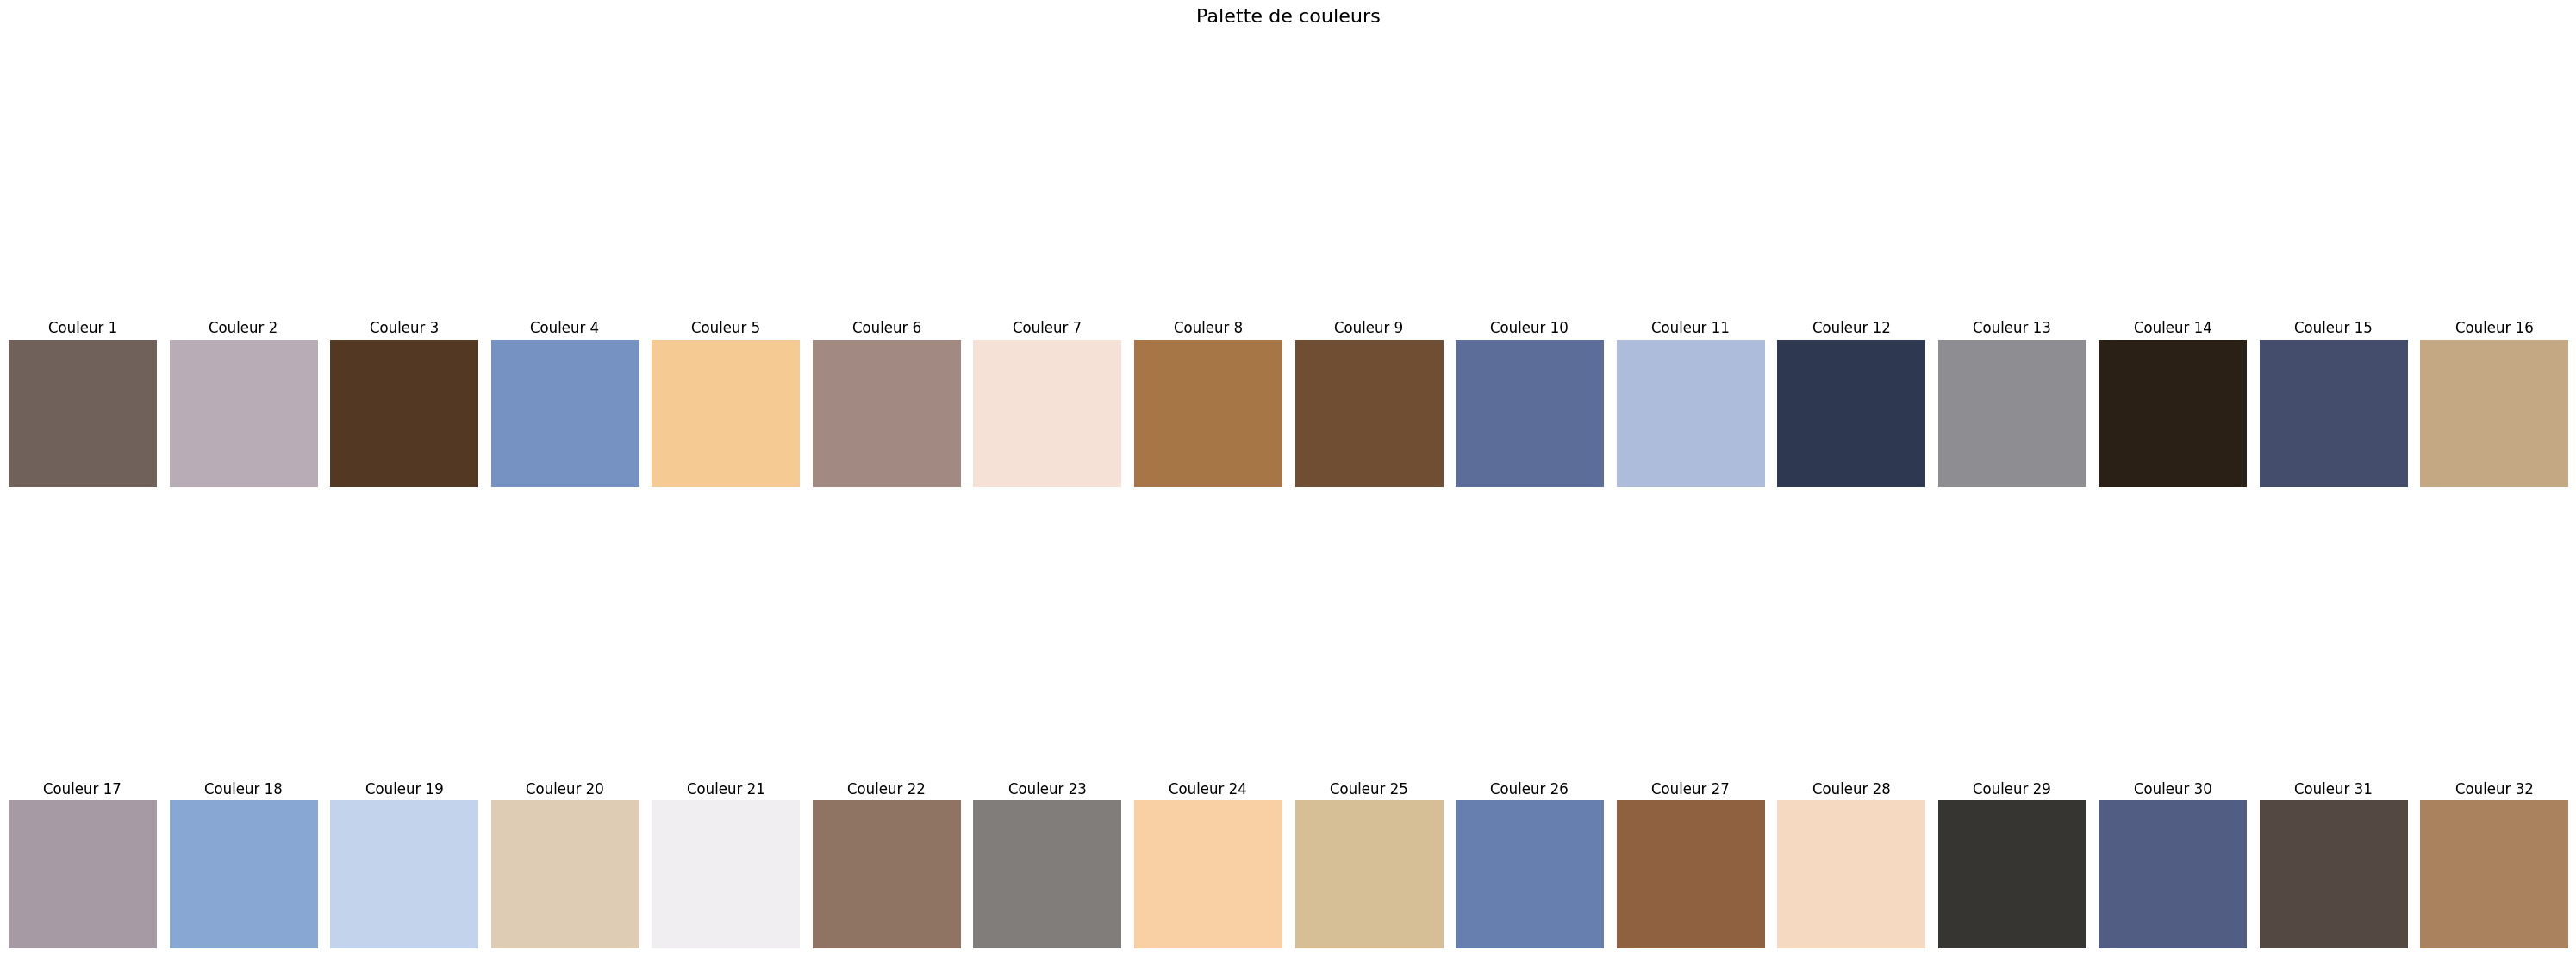

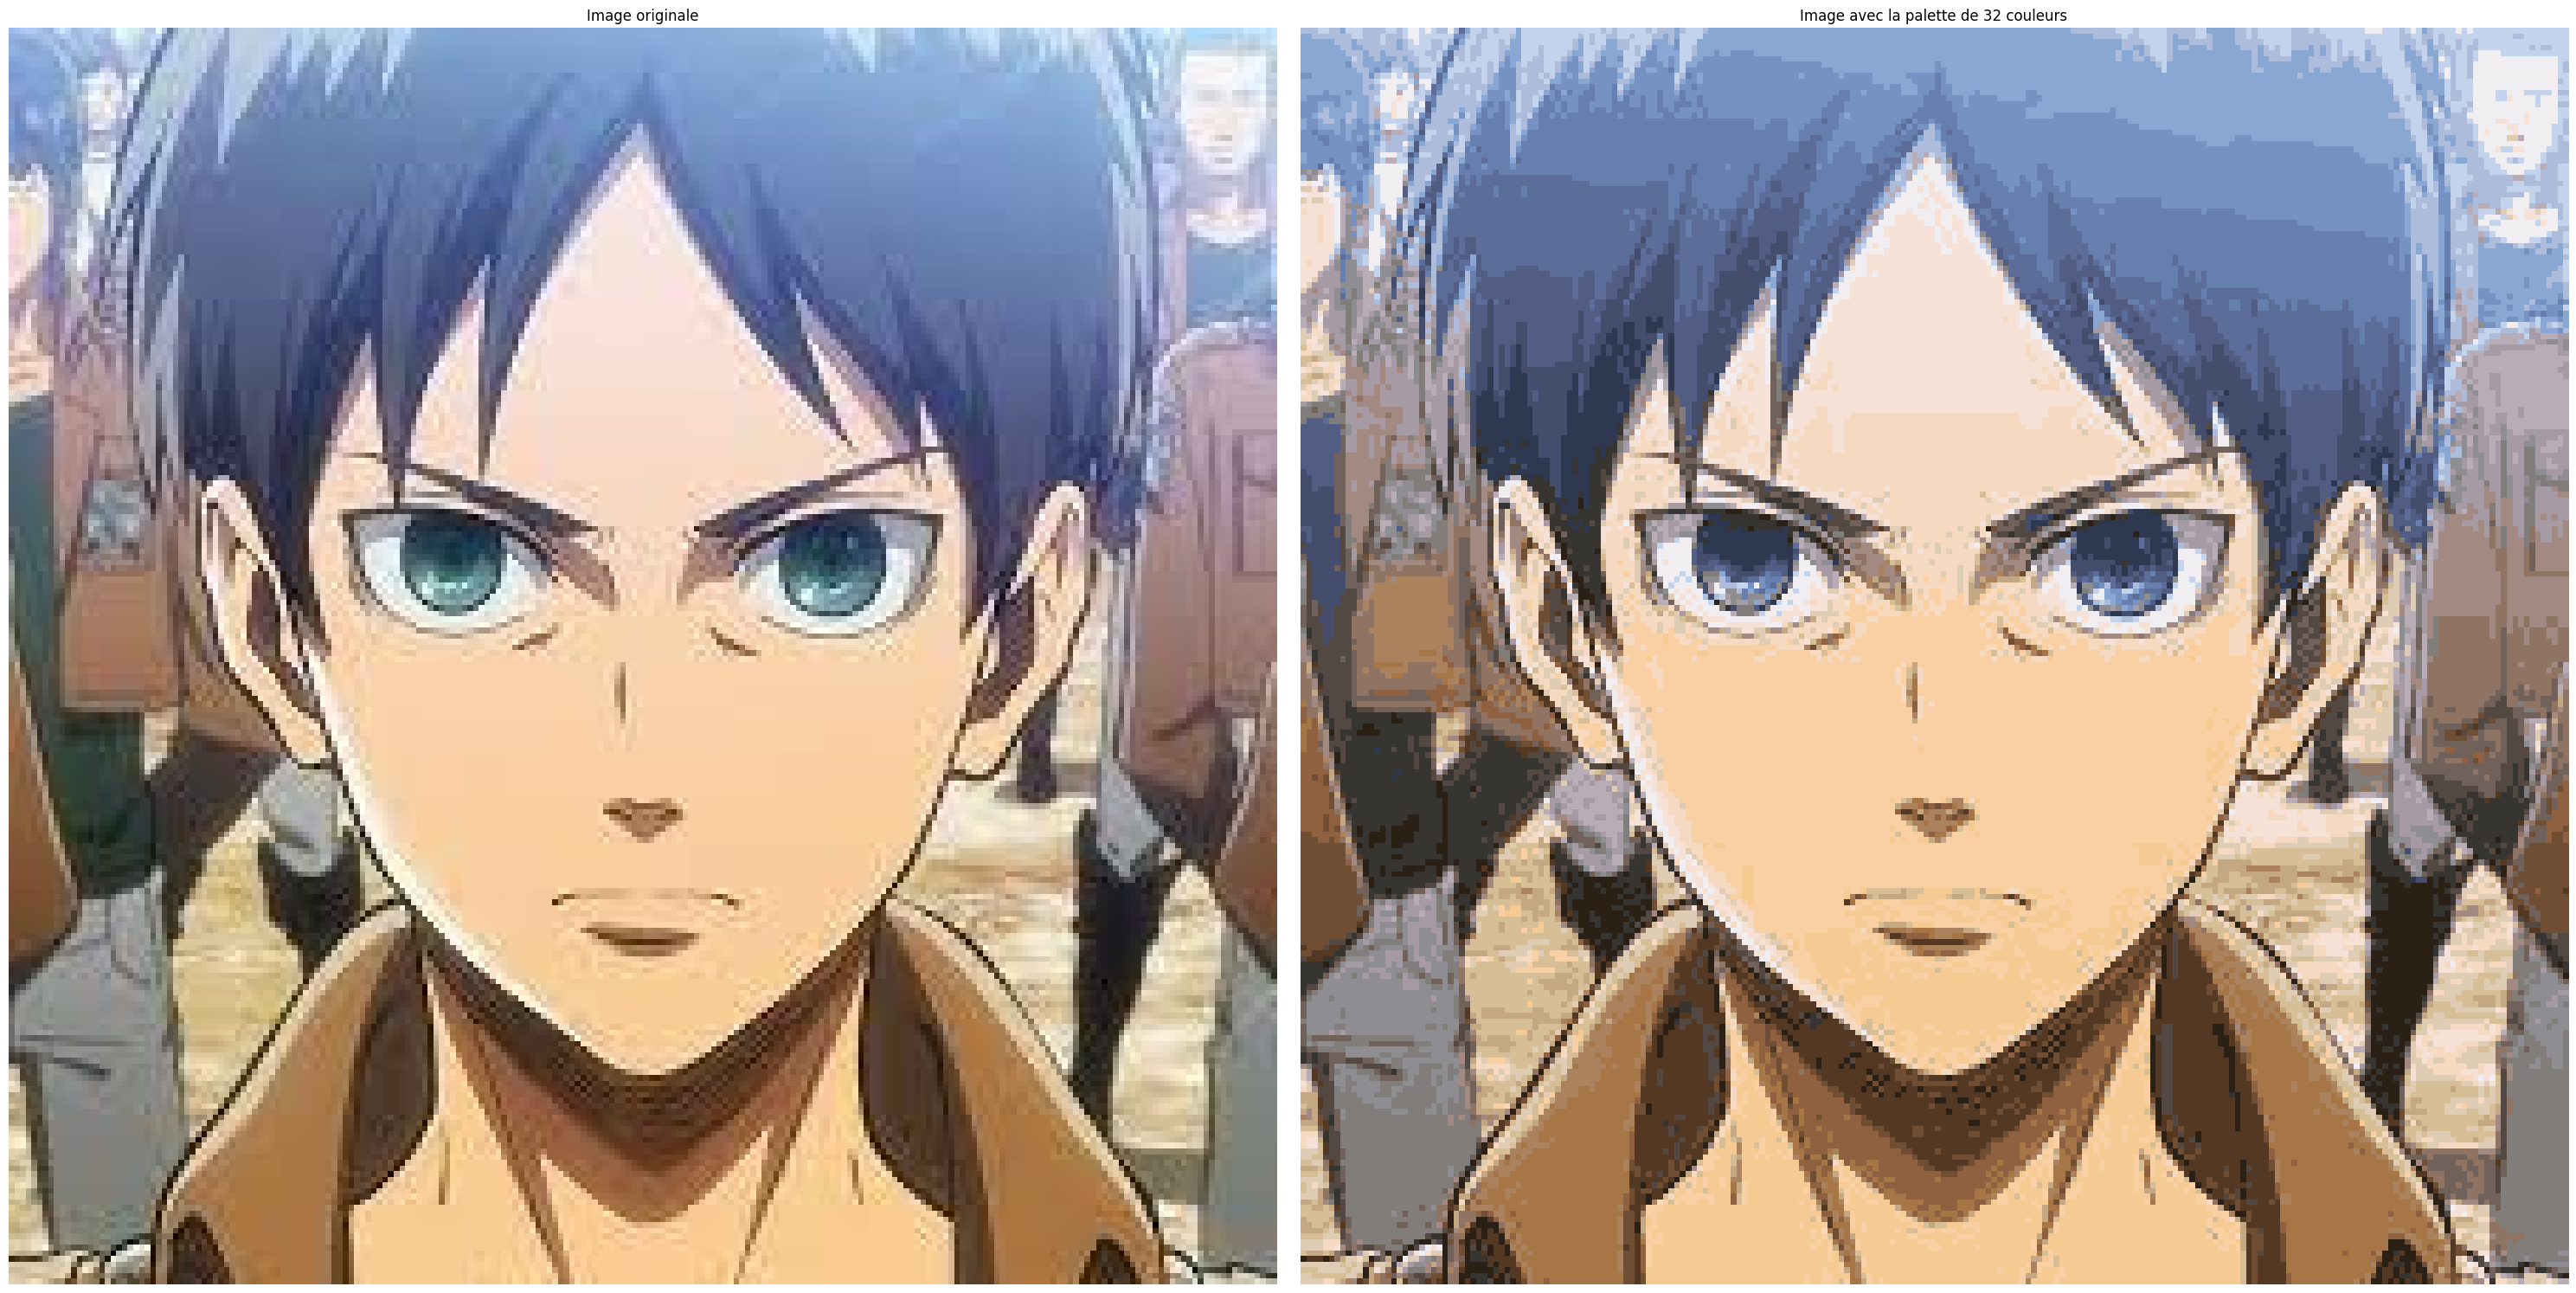

MSE entre l'image originale et l'image reconstruite 1: 137.47166586229085


In [302]:
# Clustering des couleurs de l'image
color_palette1, palette_indices1 = kmeans_clustering_palette(image, num_colors)

# Reconstruction de l'image à partir de la palette de couleurs
reconstructed_image1 = inverse_kmeans_clustering_palette(color_palette1, palette_indices1)

# Afficher l'image originale avec la palette de couleurs
display_image_with_palette(image, color_palette1, palette_indices1, num_rows)

# Calculer la MSE entre l'image originale et l'image reconstruite
mse_value1 = MSE(image, reconstructed_image1)
print("MSE entre l'image originale et l'image reconstruite 1:", mse_value1)

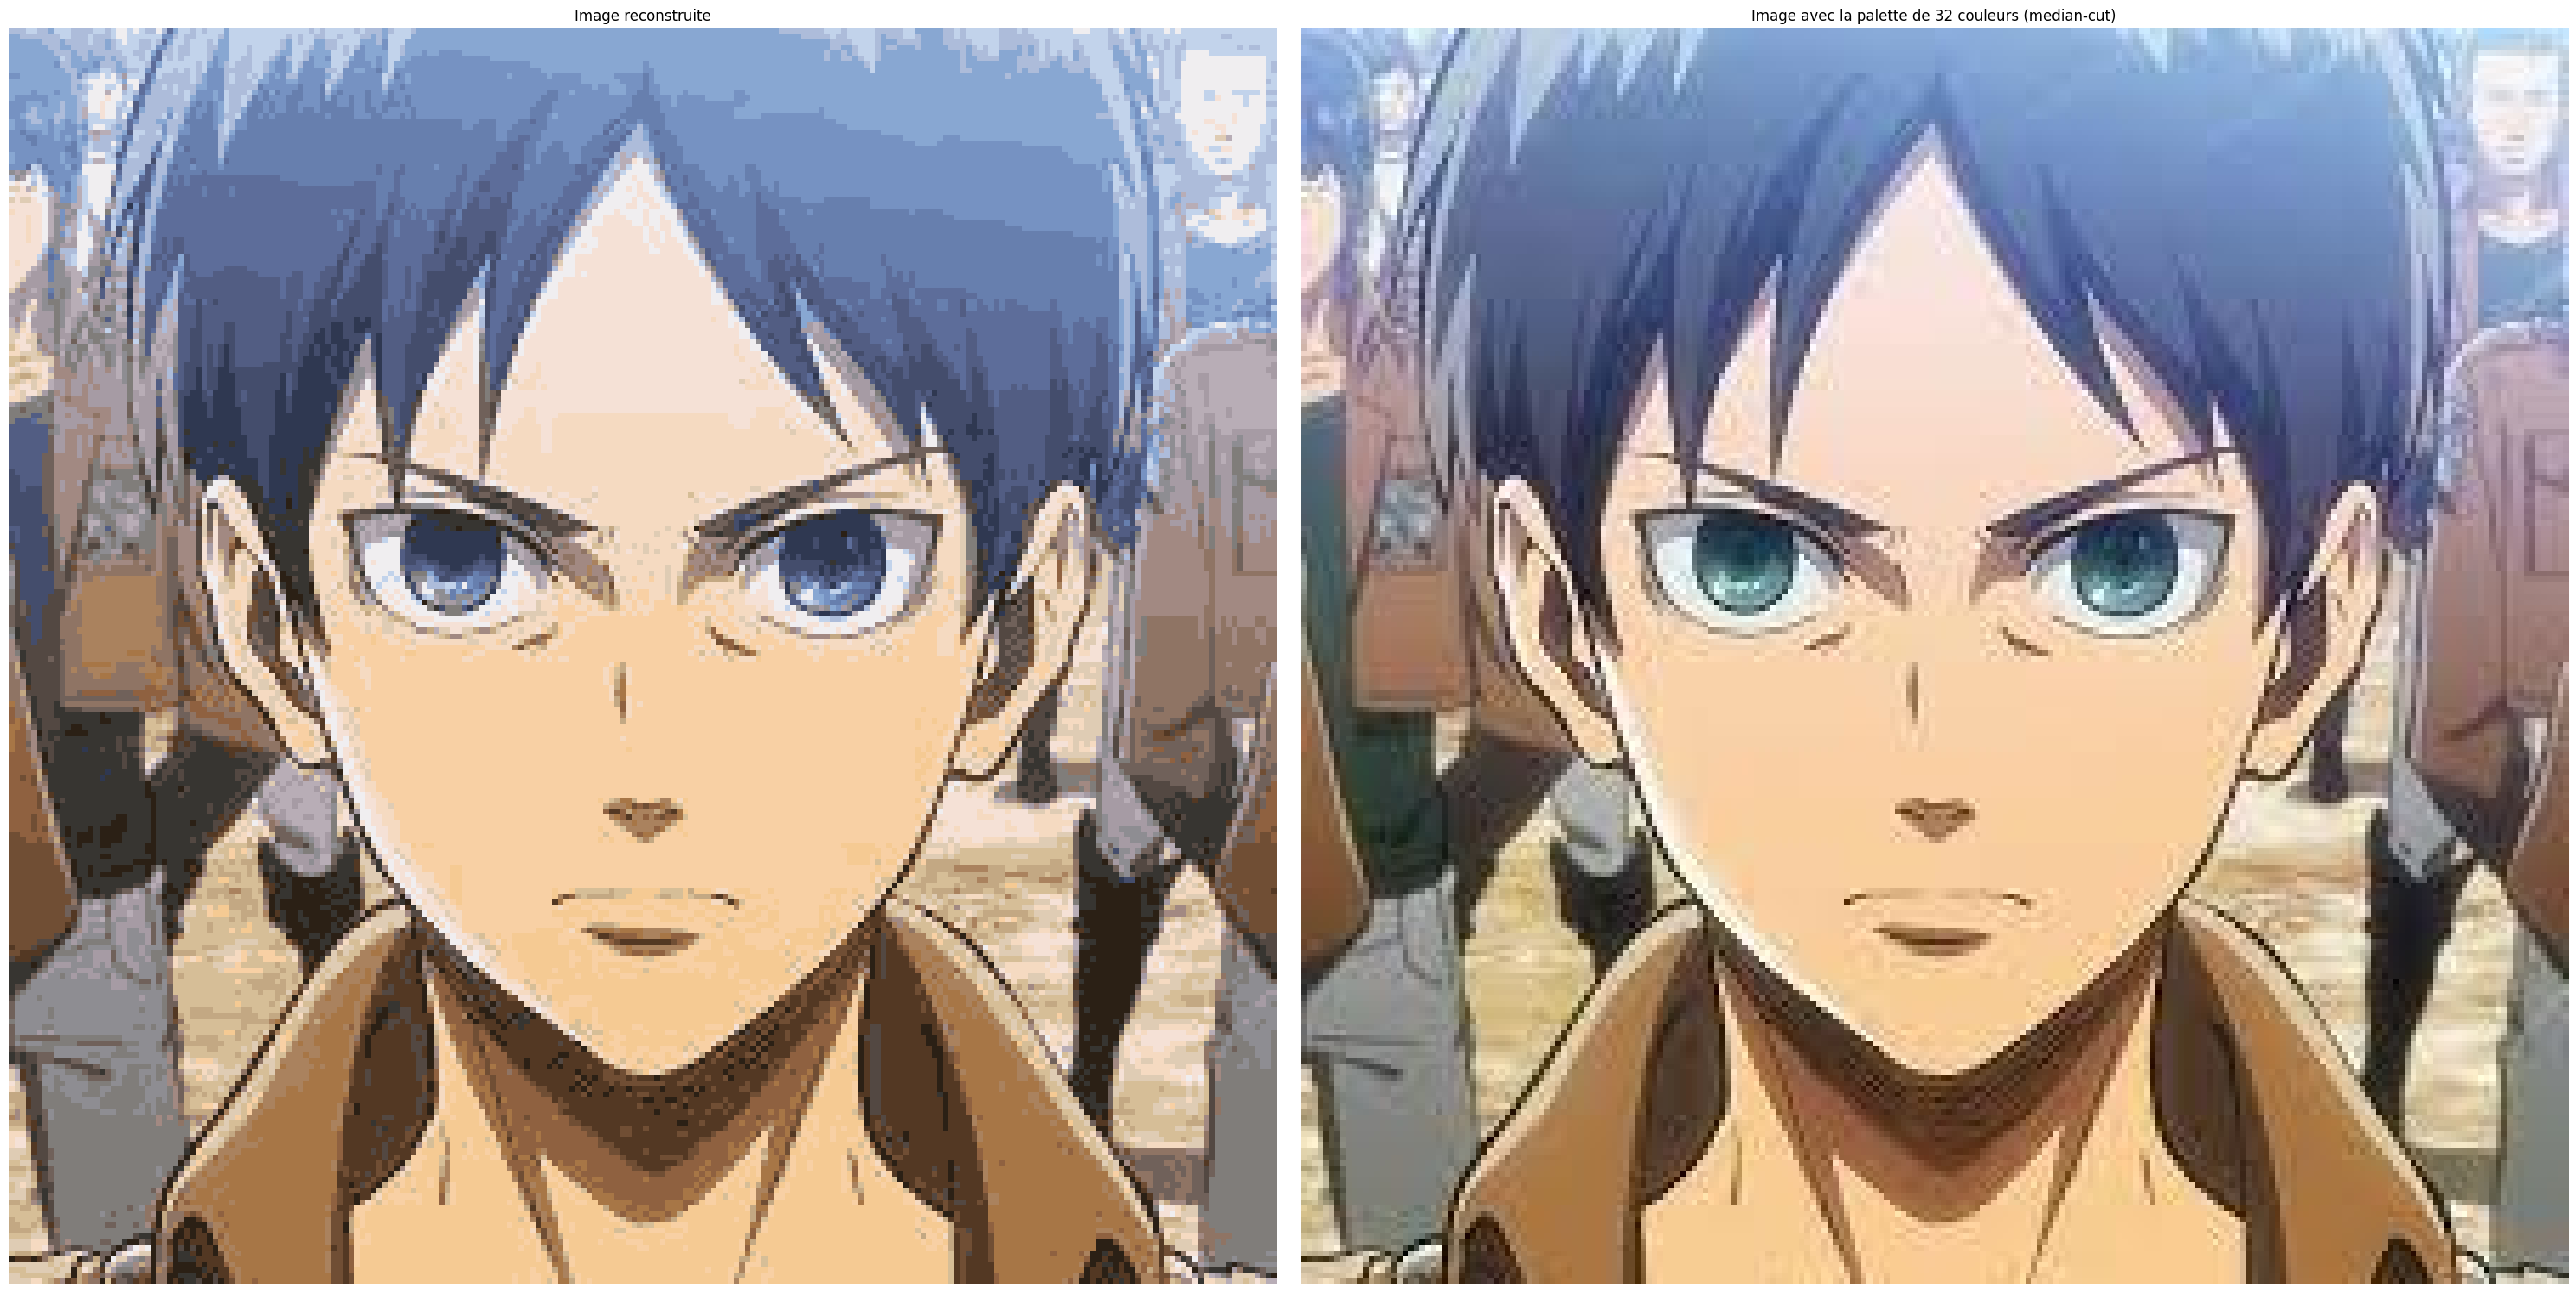

In [303]:
# Afficher l'image reconstruite et l'image originale avec la palette de couleurs
plot_images(reconstructed_image1, image, num_colors)

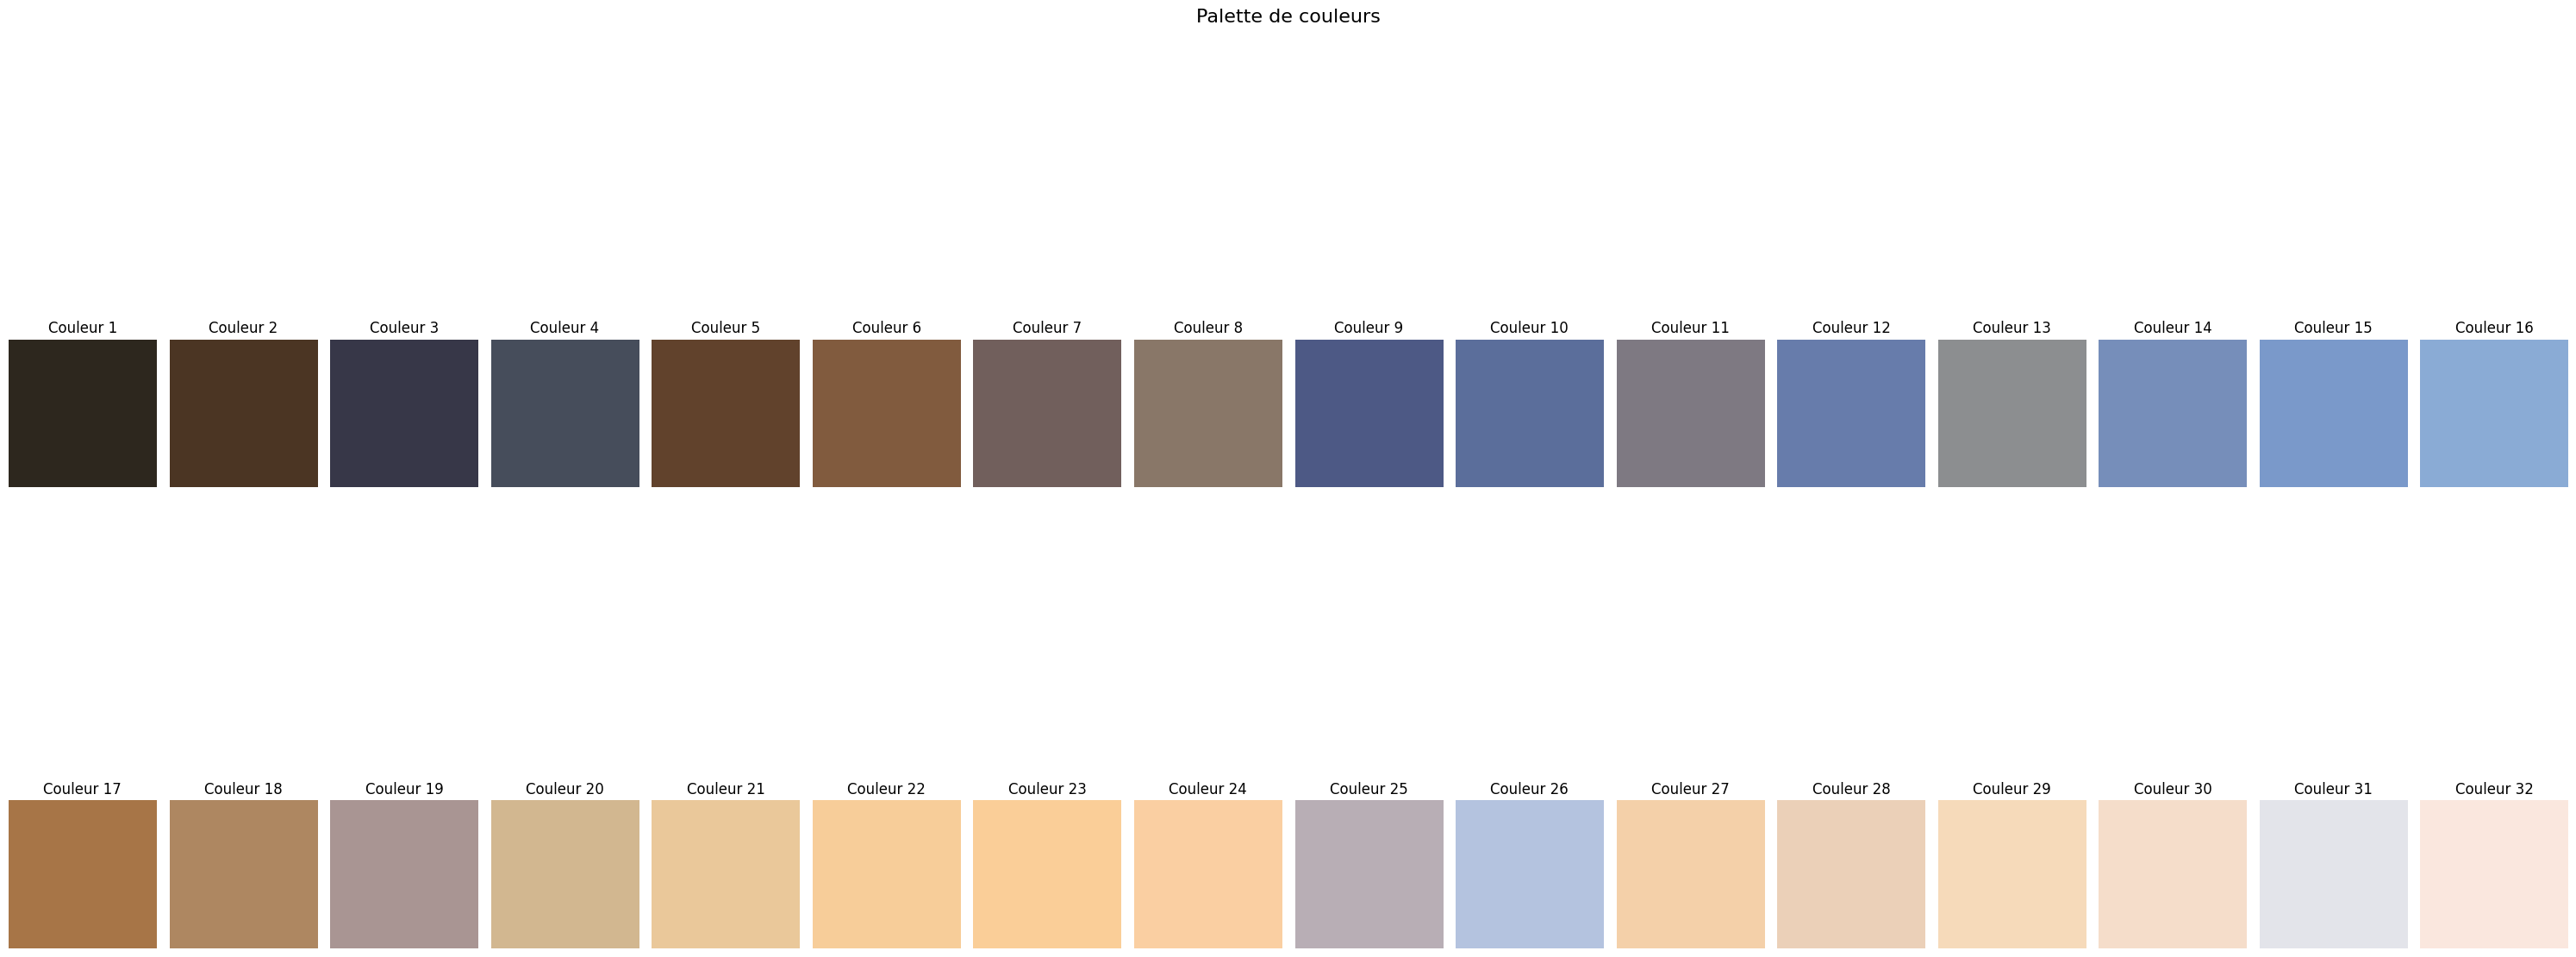

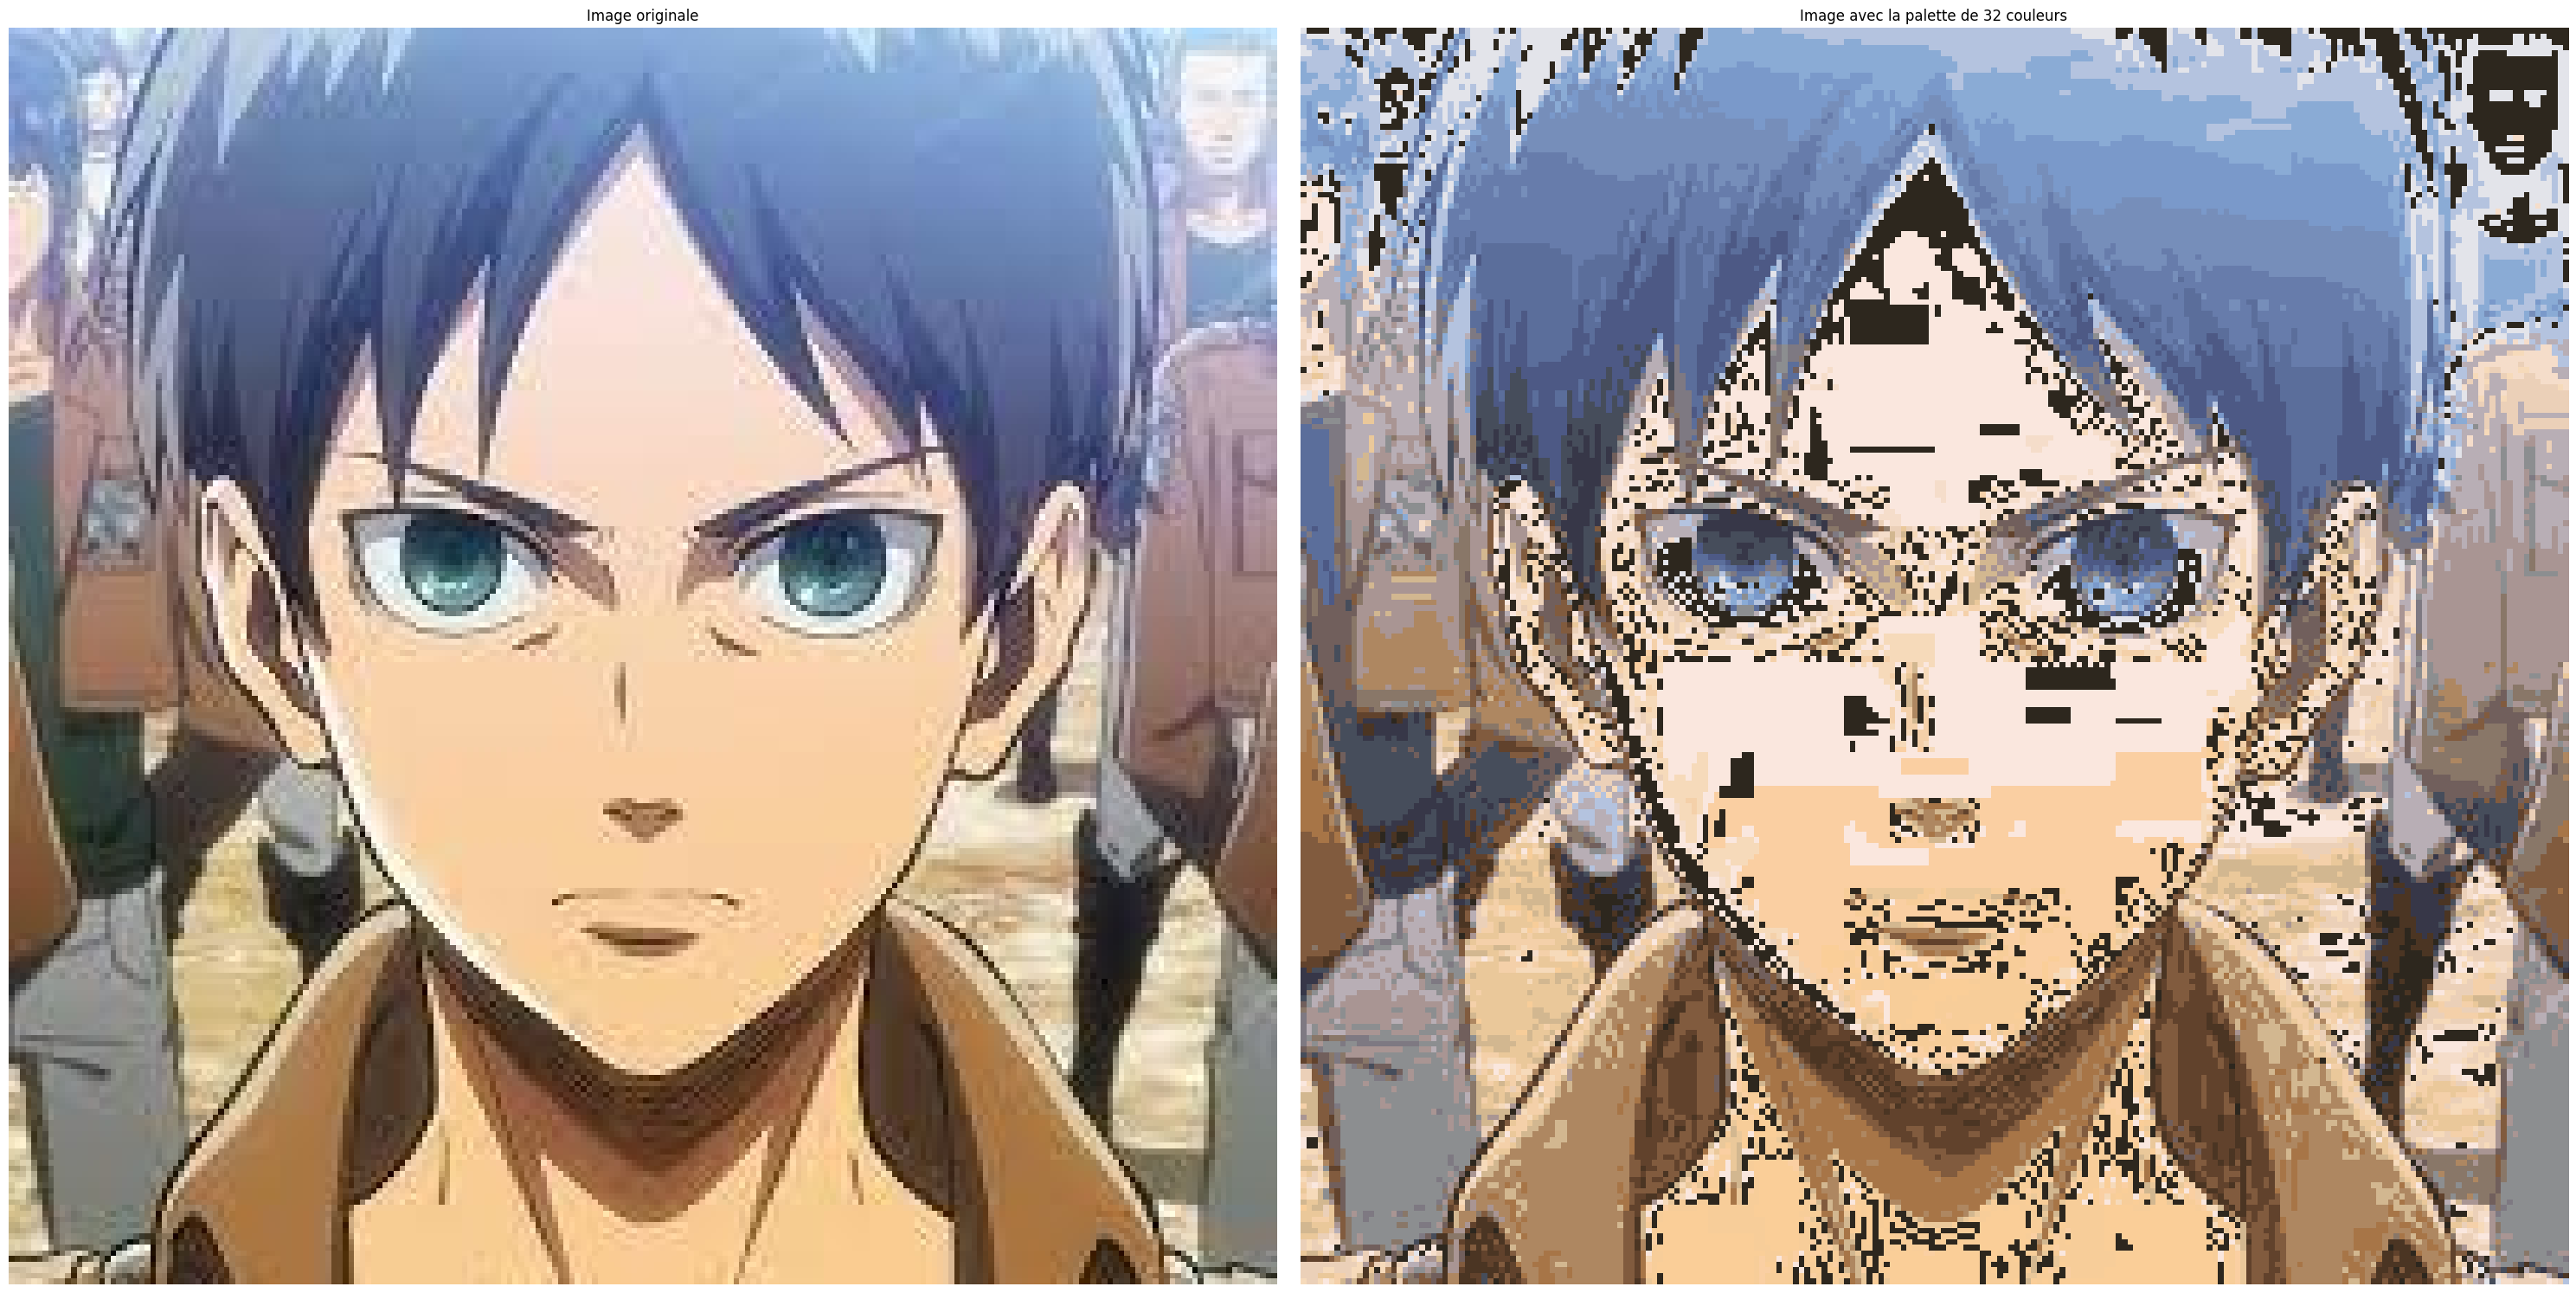

MSE entre l'image originale et l'image reconstruite 2 : 259.0914575289575


In [304]:
# Clustering des couleurs de l'image
color_palette2, palette_indices2 = median_cut_palette(image, num_colors)

# Reconstruction de l'image à partir de la palette de couleurs
reconstructed_image2 = inverse_median_cut_palette(color_palette2, palette_indices2)

# Afficher l'image originale avec la palette de couleurs
display_image_with_palette(image, color_palette2, palette_indices2, num_rows)

# Calculer la MSE entre l'image originale et l'image reconstruite
mse_value2 = MSE(image, reconstructed_image2)
print("MSE entre l'image originale et l'image reconstruite 2 :", mse_value2)

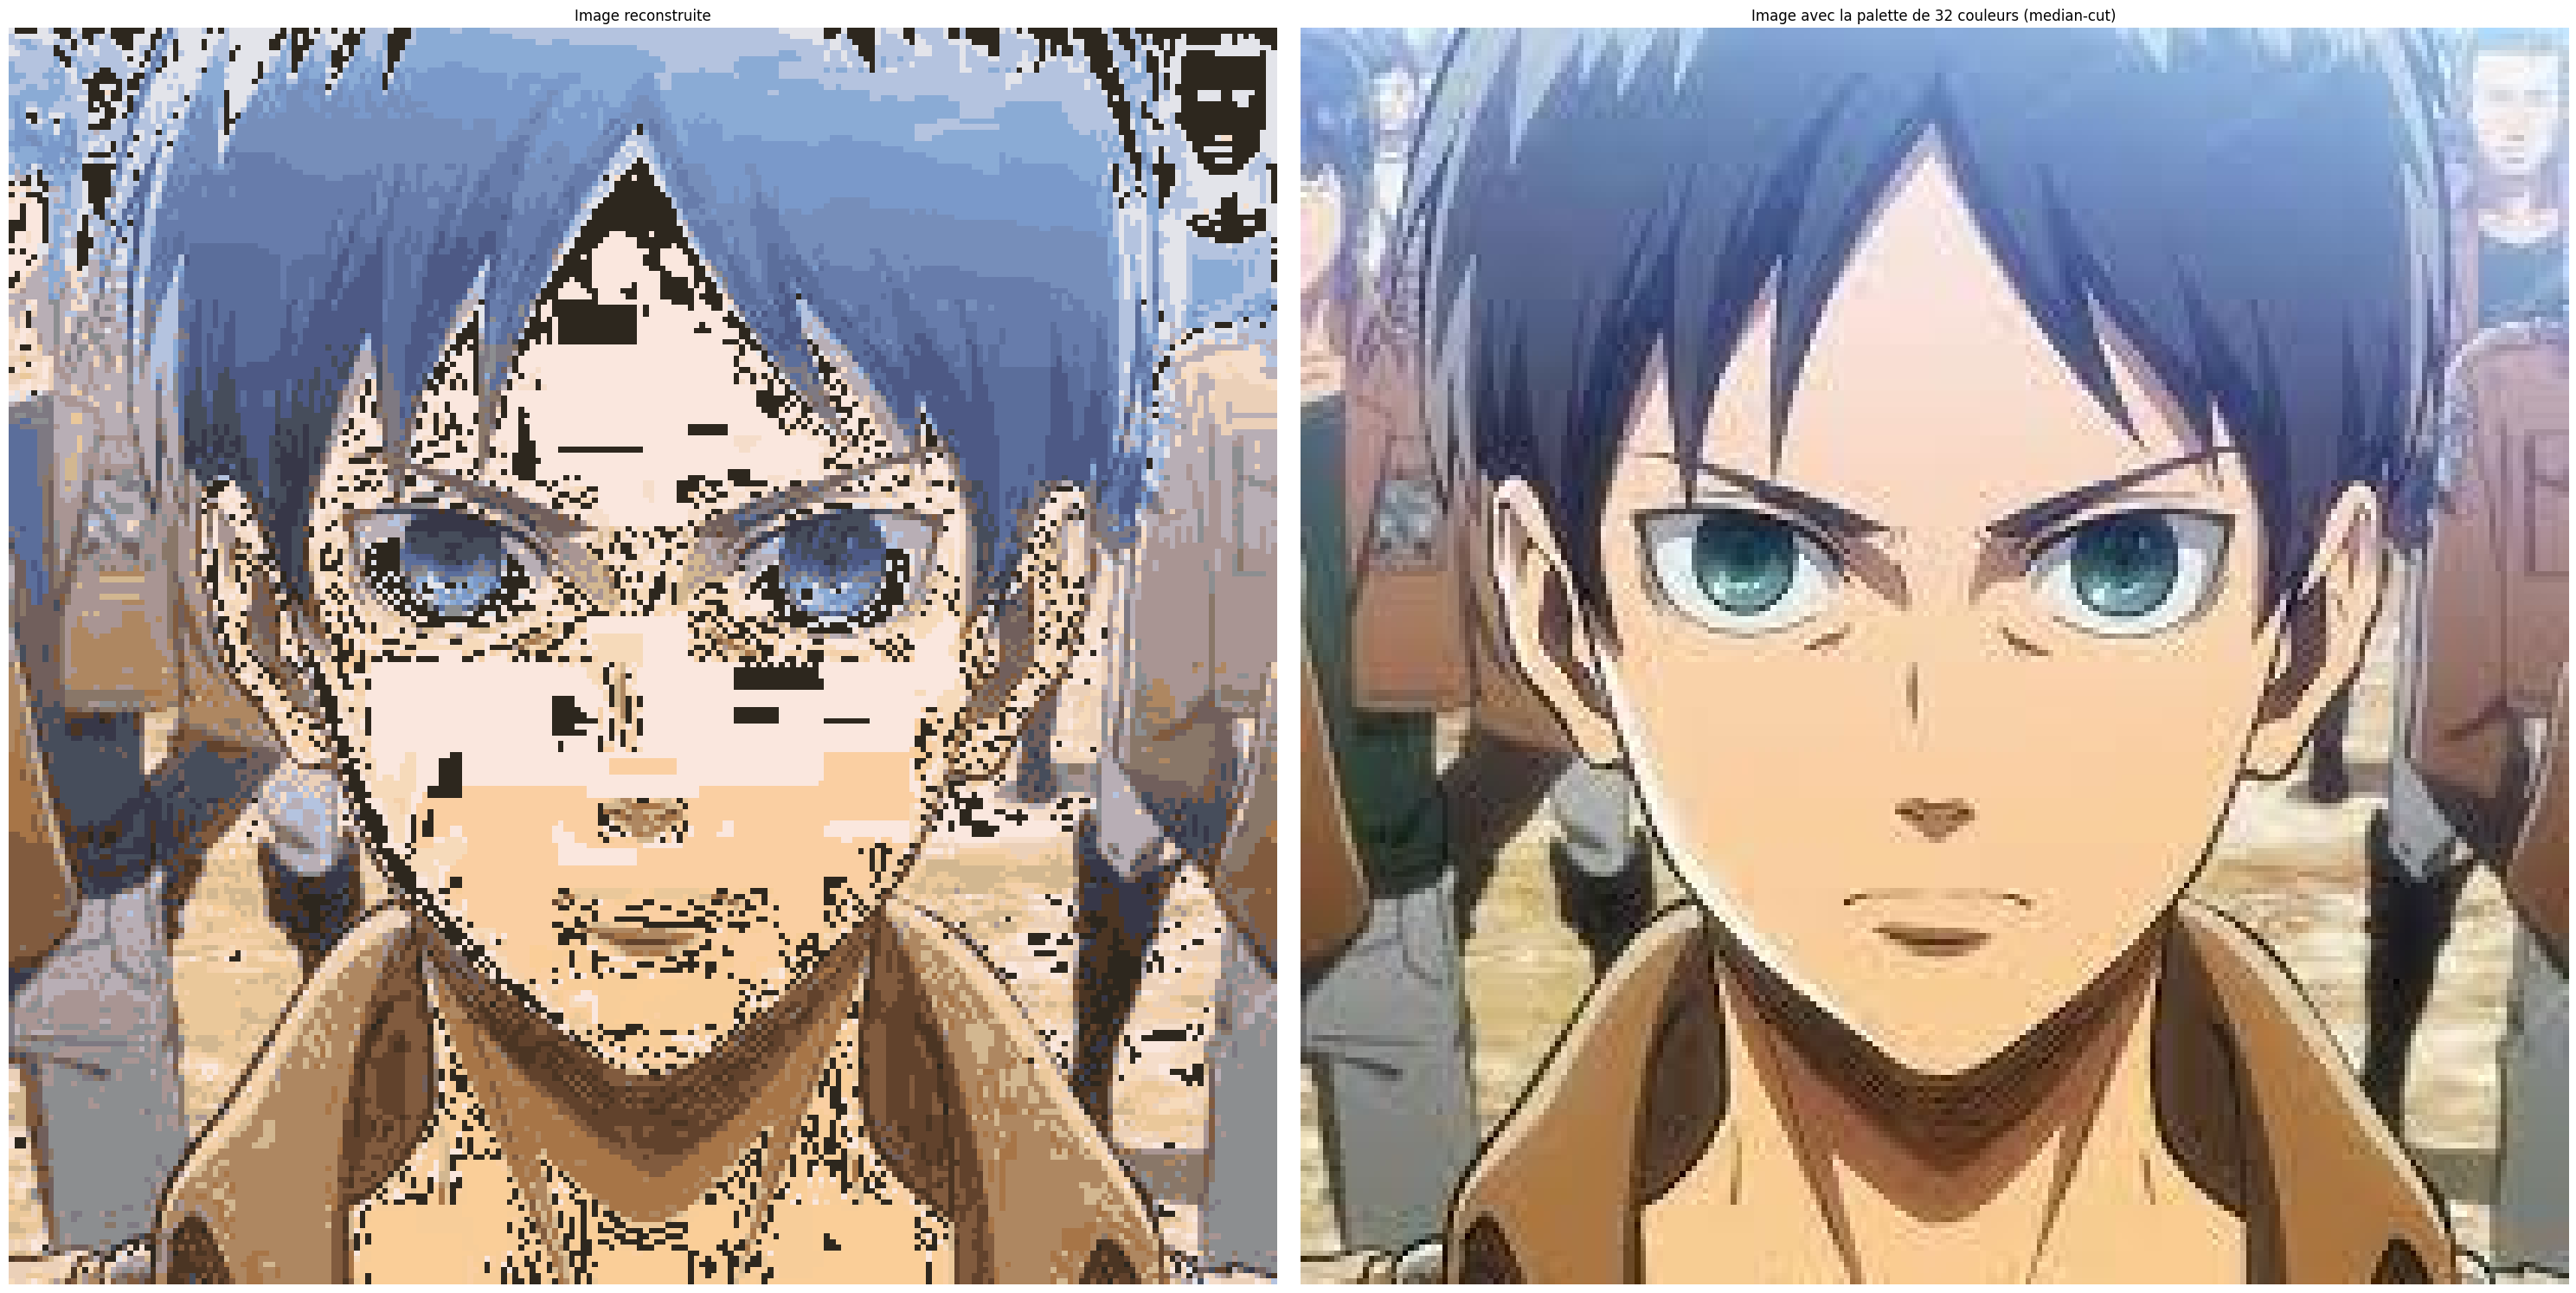

In [305]:
# Afficher l'image reconstruite et l'image originale avec la palette de couleurs
plot_images(reconstructed_image2, image, num_colors)

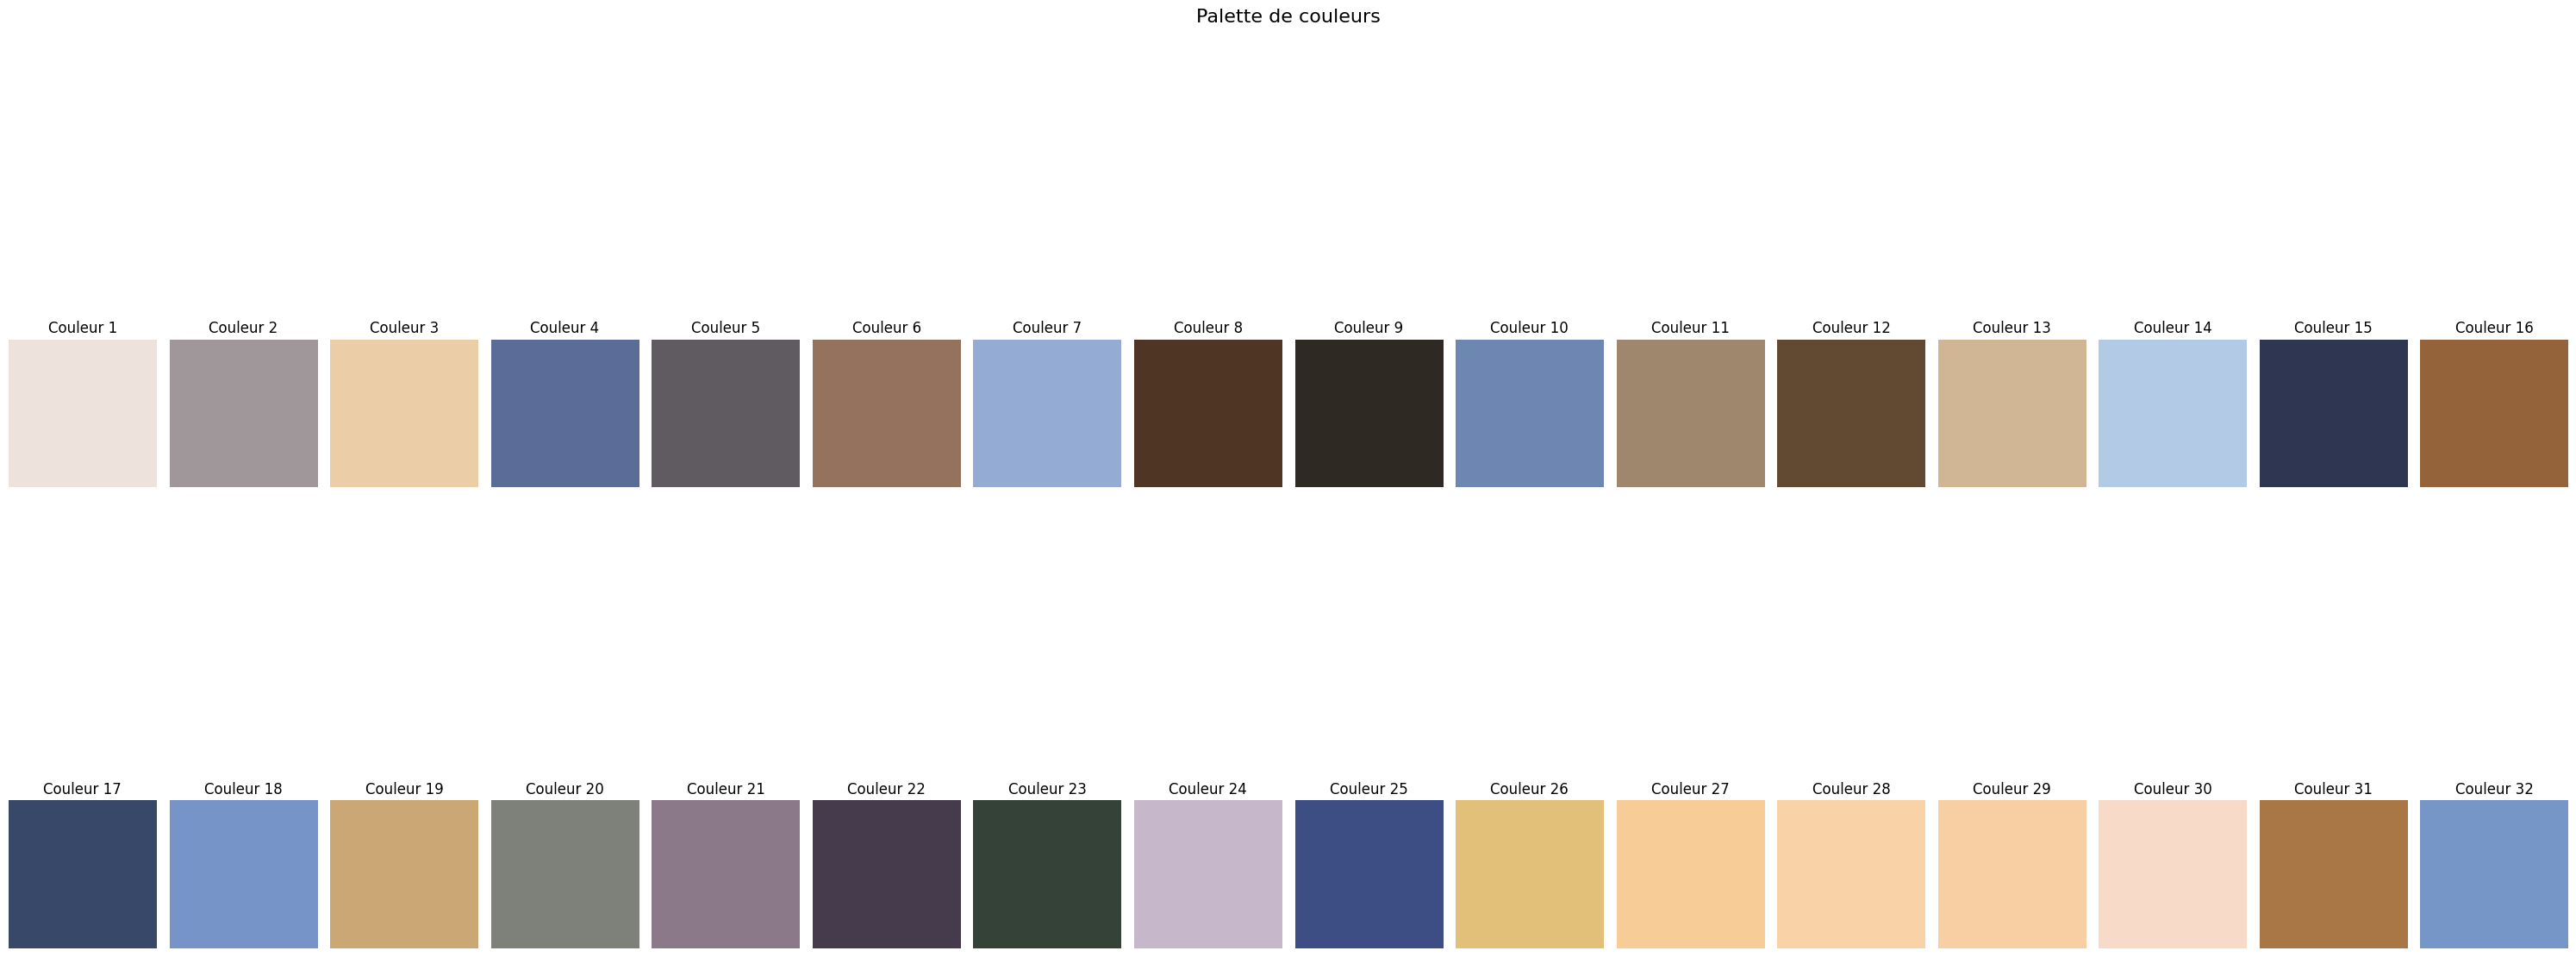

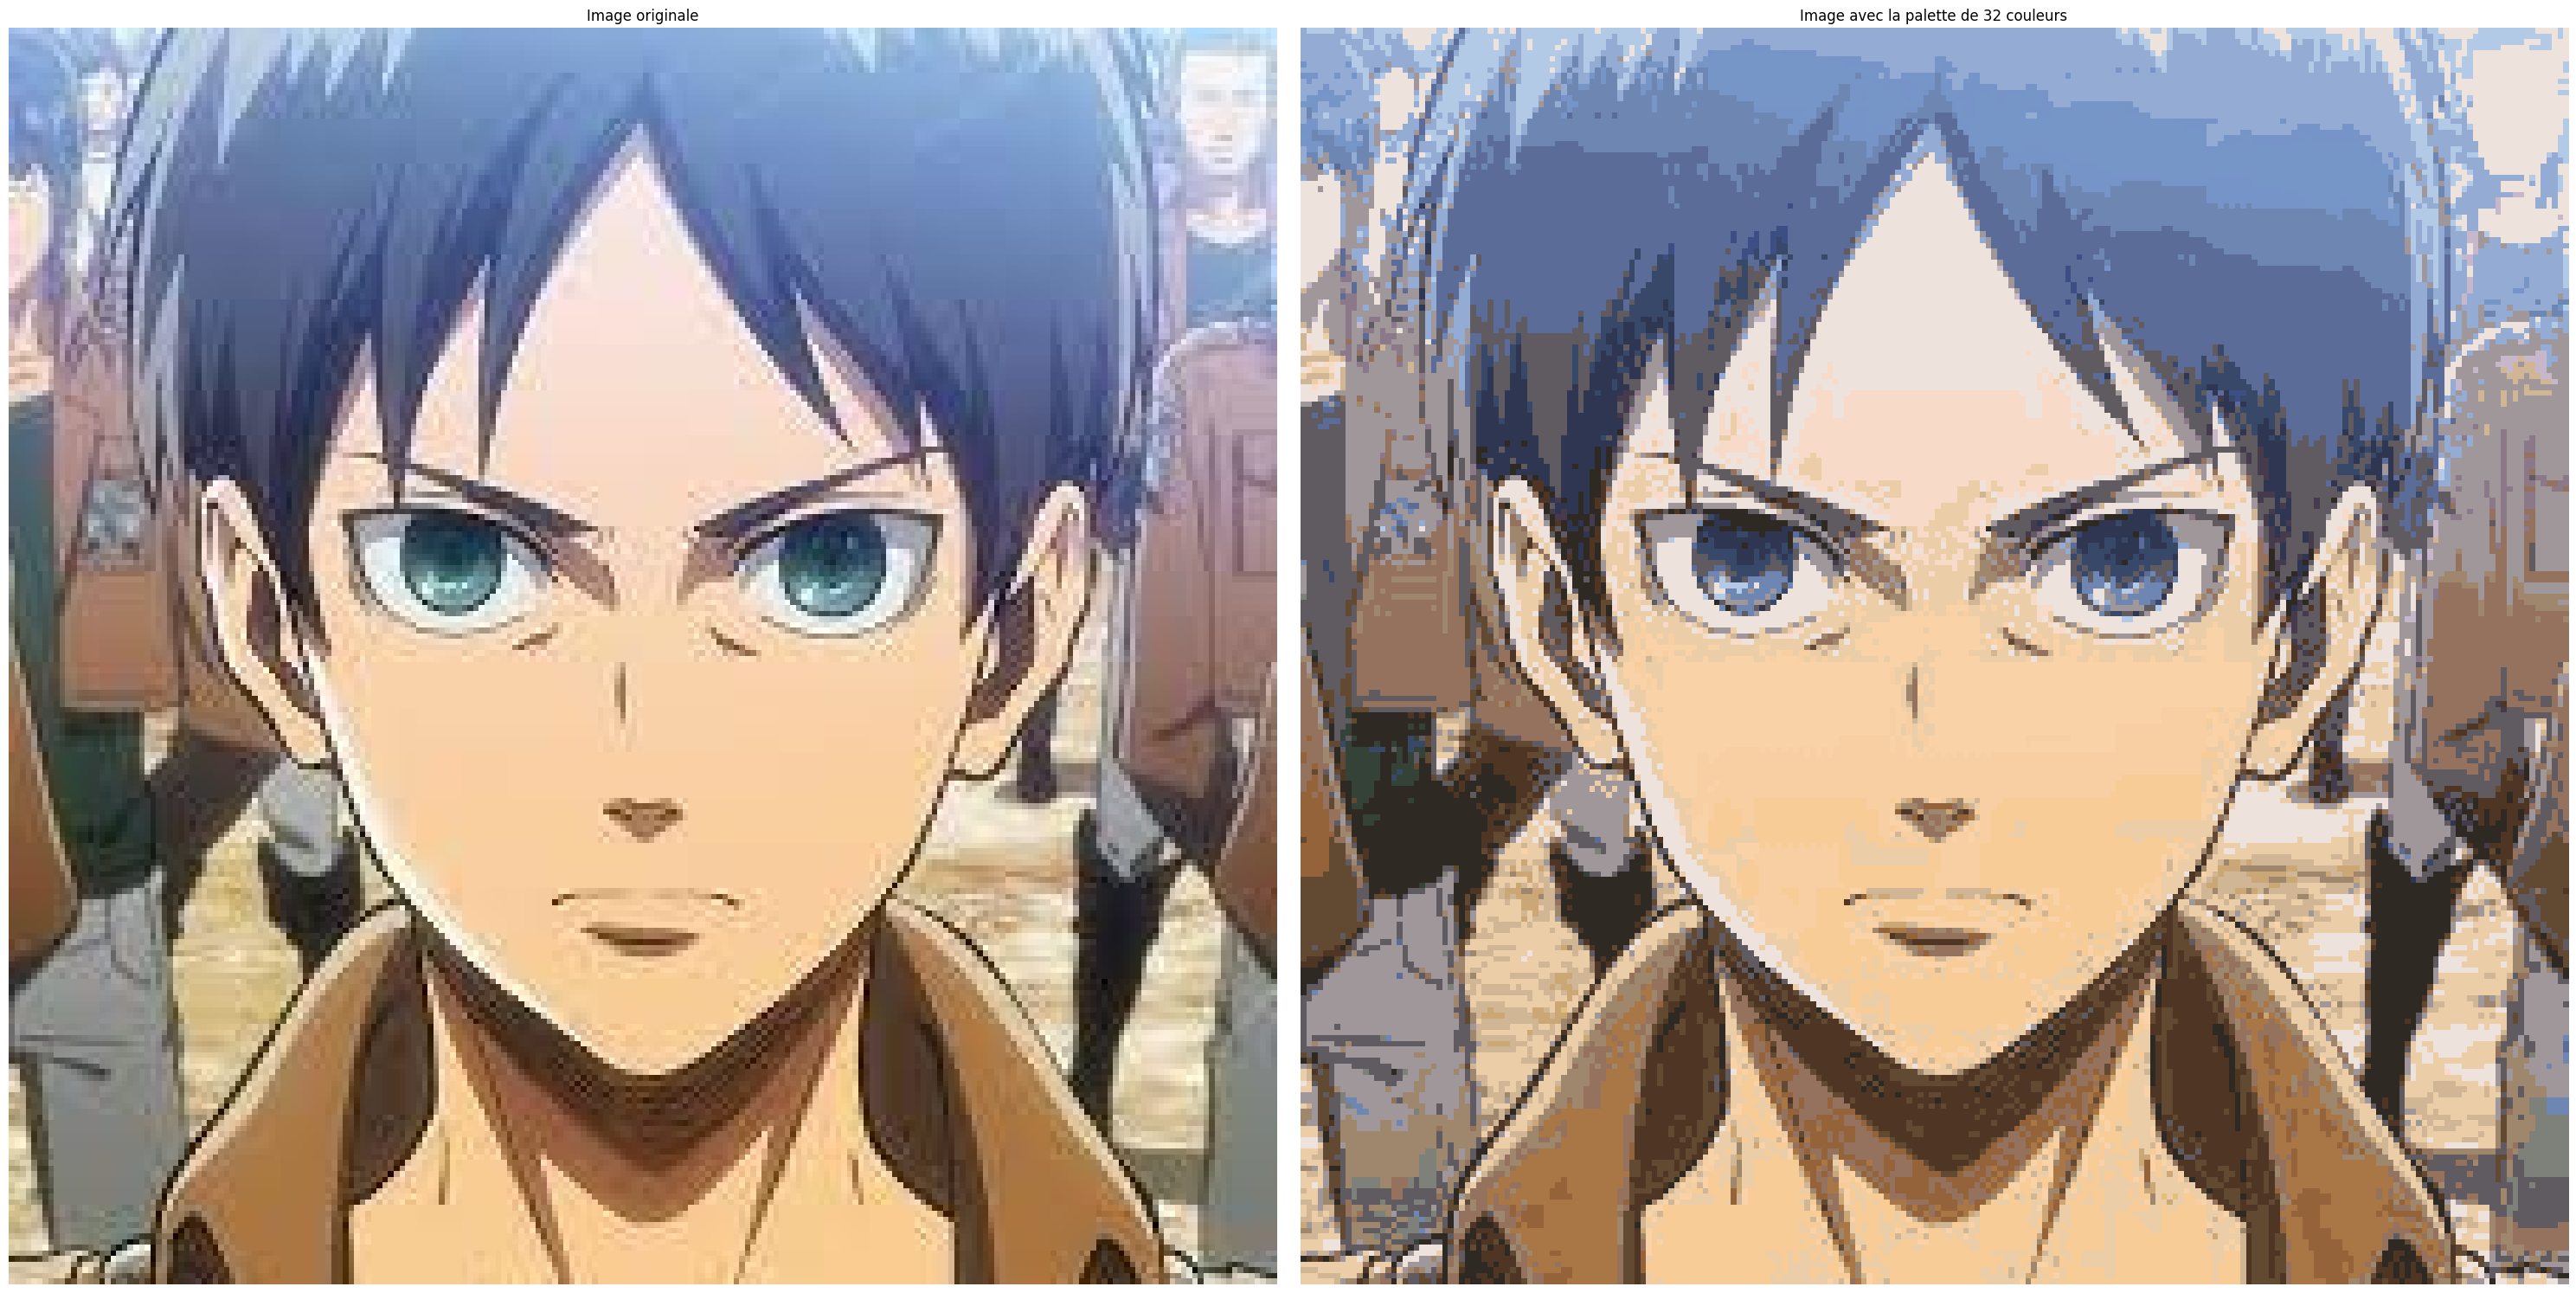

MSE entre l'image originale et l'image reconstruite 3 : 180.92109073359072


In [306]:
# Clustering des couleurs de l'image
color_palette3, palette_indices3 = octree_palette(image, num_colors)

# Reconstruction de l'image à partir de la palette de couleurs
reconstructed_image3 = inverse_octree_palette(color_palette3, palette_indices3)

# Afficher l'image originale avec la palette de couleurs
display_image_with_palette(image, color_palette3, palette_indices3, num_rows)

# Calculer la MSE entre l'image originale et l'image reconstruite
mse_value3 = MSE(image, reconstructed_image3)
print("MSE entre l'image originale et l'image reconstruite 3 :", mse_value3)

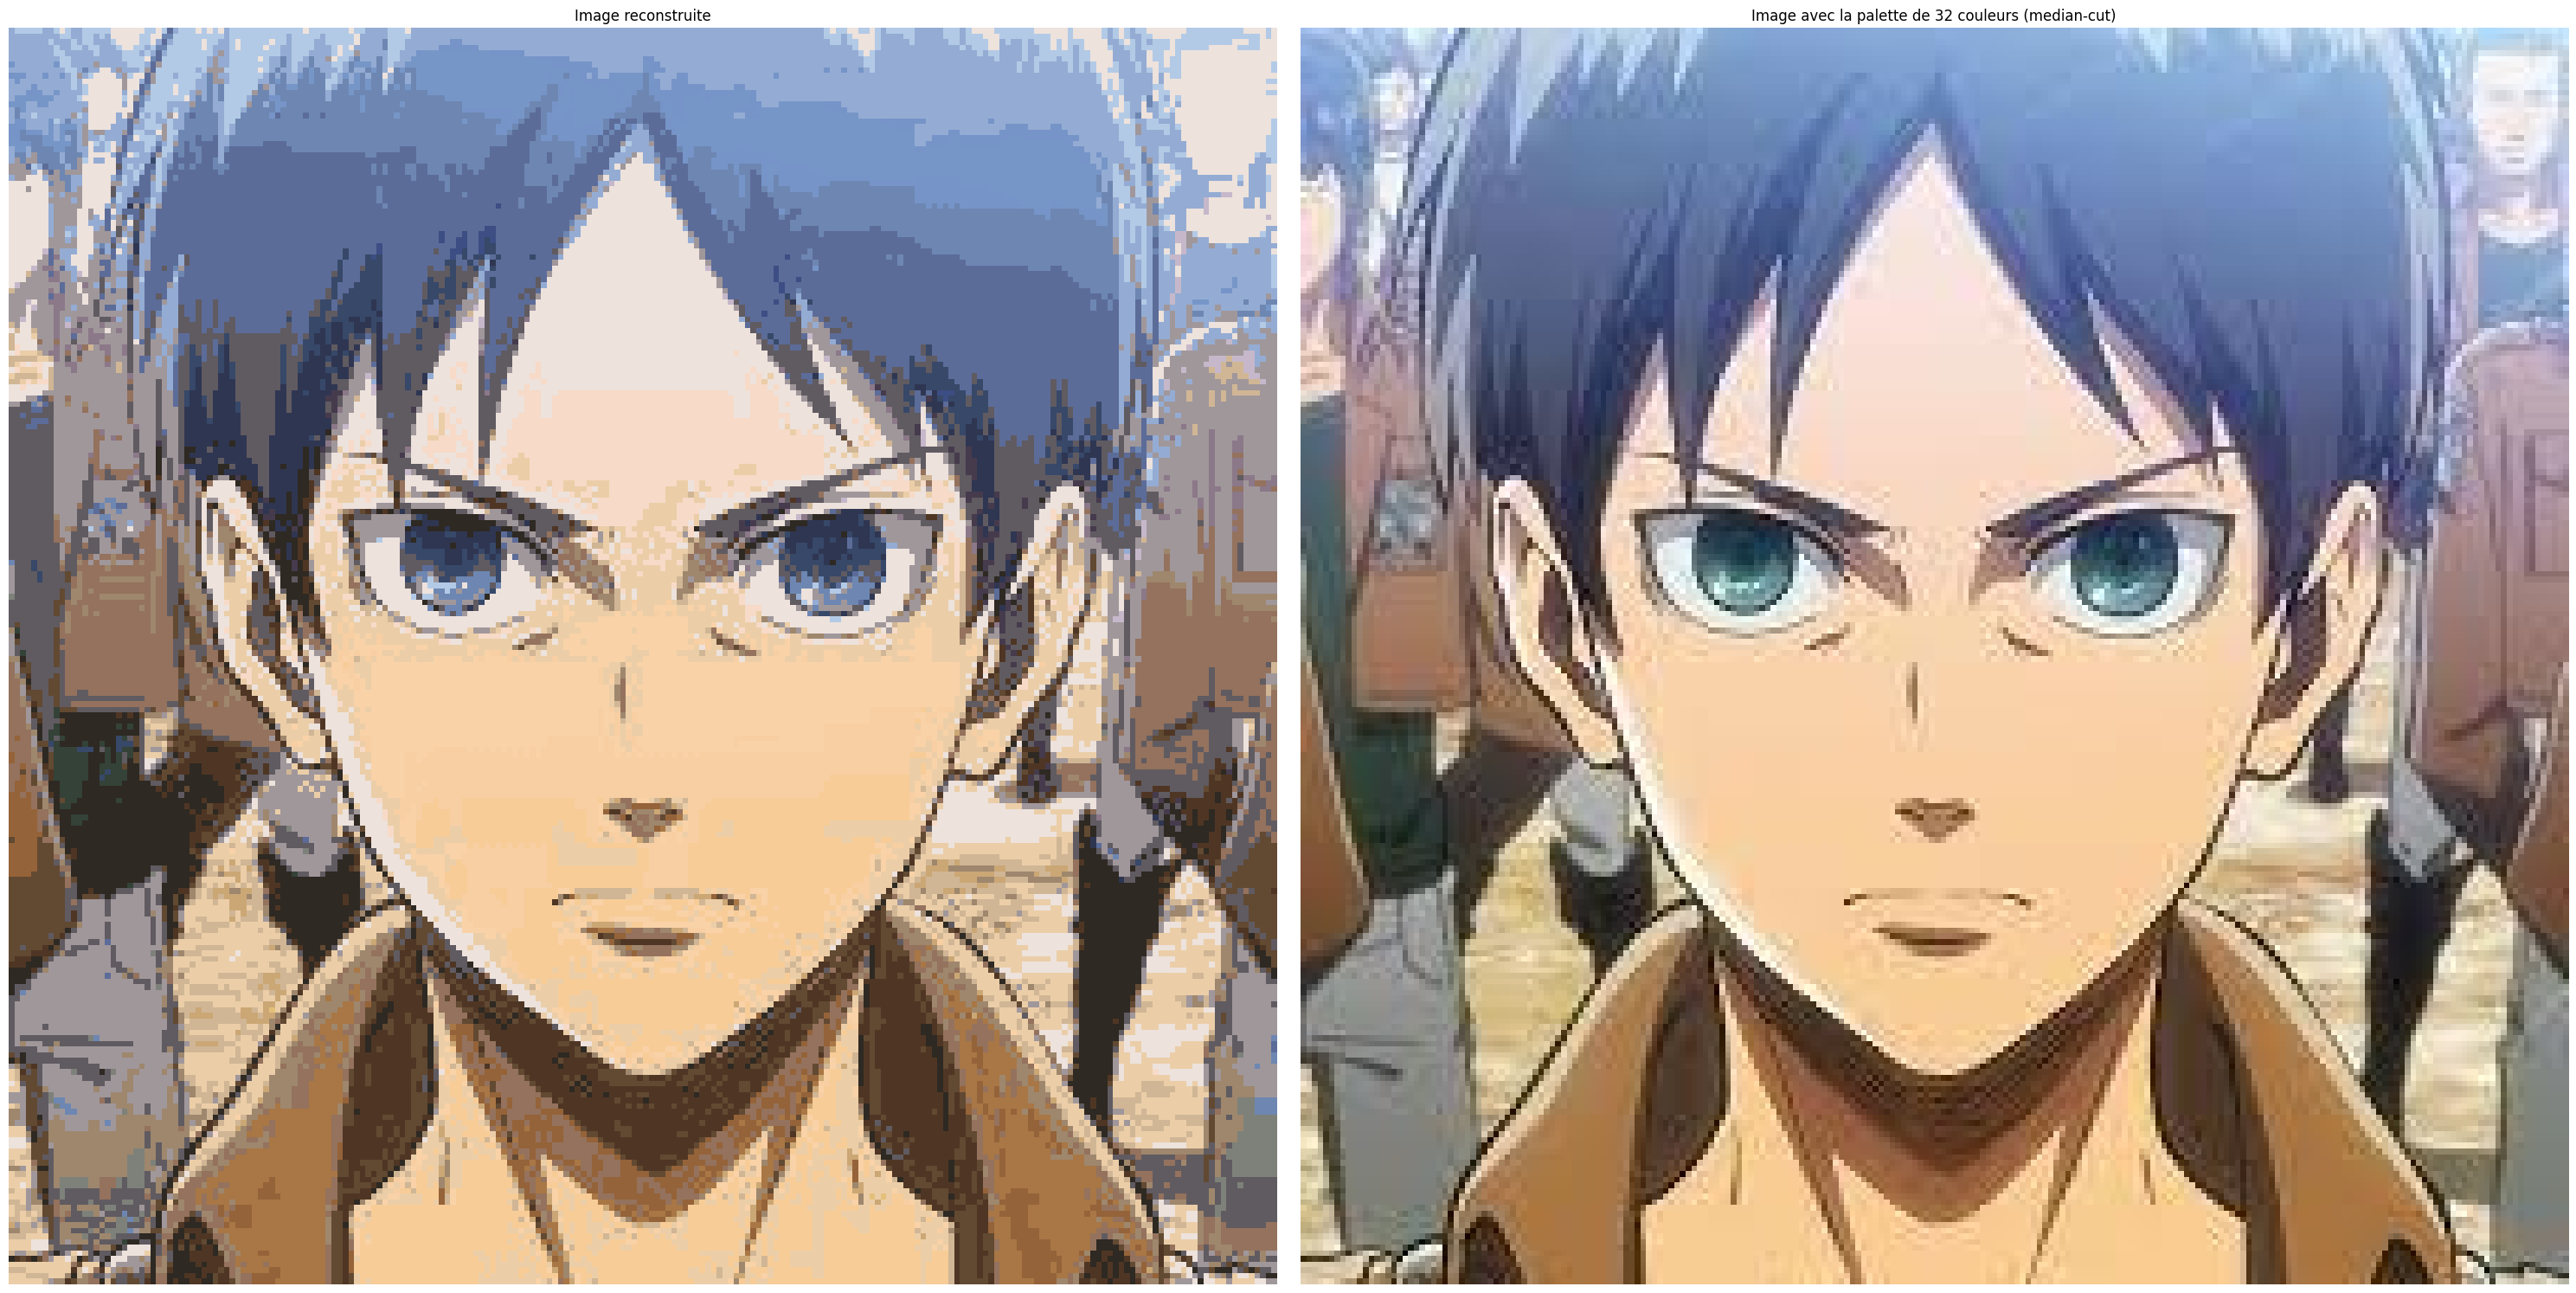

In [307]:
# Afficher l'image reconstruite et l'image originale avec la palette de couleurs
plot_images(reconstructed_image3, image, num_colors)

In [226]:
def map_to_palette(image, color_palette):
    # Assurez-vous que l'image est sous forme de tableau numpy
    image = np.array(image)
    
    # Redimensionner les pixels en une matrice (nombre de pixels, 3 canaux de couleur)
    pixels = np.reshape(image, (-1, 3))  

    # Calculer la distance de chaque pixel à chaque couleur de la palette
    distances = np.linalg.norm(pixels[:, np.newaxis] - color_palette, axis=2)

    # Obtenir l'indice de la couleur la plus proche pour chaque pixel
    indices = np.argmin(distances, axis=1)

    # Reformater les indices des couleurs selon la forme de l'image originale
    mapped_indices = np.reshape(indices, image.shape[:2])
    return mapped_indices

In [286]:
def inverse_map_to_palette(mapped_indices, color_palette):
    height, width = mapped_indices.shape
    reconstructed_image = Image.new('RGB', (width, height))

    for i in range(height):
        for j in range(width):
            color_index = mapped_indices[i, j]
            if color_index >= len(color_palette):
                color_index = len(color_palette) - 1  # Assure que l'indice reste dans les limites de la palette
            color = color_palette[color_index]
            reconstructed_image.putpixel((j, i), tuple(color))

    return reconstructed_image

In [287]:
# Application de la fonction map_to_palette
mapped_indices1 = map_to_palette(image, color_palette1)

# Reconstruction de l'image à partir des indices mappés
reconstructed_image_from_mapping1 = inverse_map_to_palette(mapped_indices1, color_palette1)

# Calcul de la MSE entre l'image originale et l'image reconstruite à partir des indices mappés
mse_mapped1 = MSE(np.array(color_palette1[palette_indices1]), reconstructed_image_from_mapping1)

# Afficher la valeur de la MSE
print("MSE entre l'image originale et l'image reconstruite 1 à partir des indices mappés:", mse_mapped1)

(222, 224)
MSE entre l'image originale et l'image reconstruite 1 à partir des indices mappés: 32.49296171171171


In [288]:
mapped_indices1

array([[ 8,  8,  8, ...,  9,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  9],
       ...,
       [11, 11, 11, ...,  7,  0,  0],
       [10, 11, 11, ...,  7,  2,  2],
       [ 1, 10, 11, ...,  1, 11,  6]])

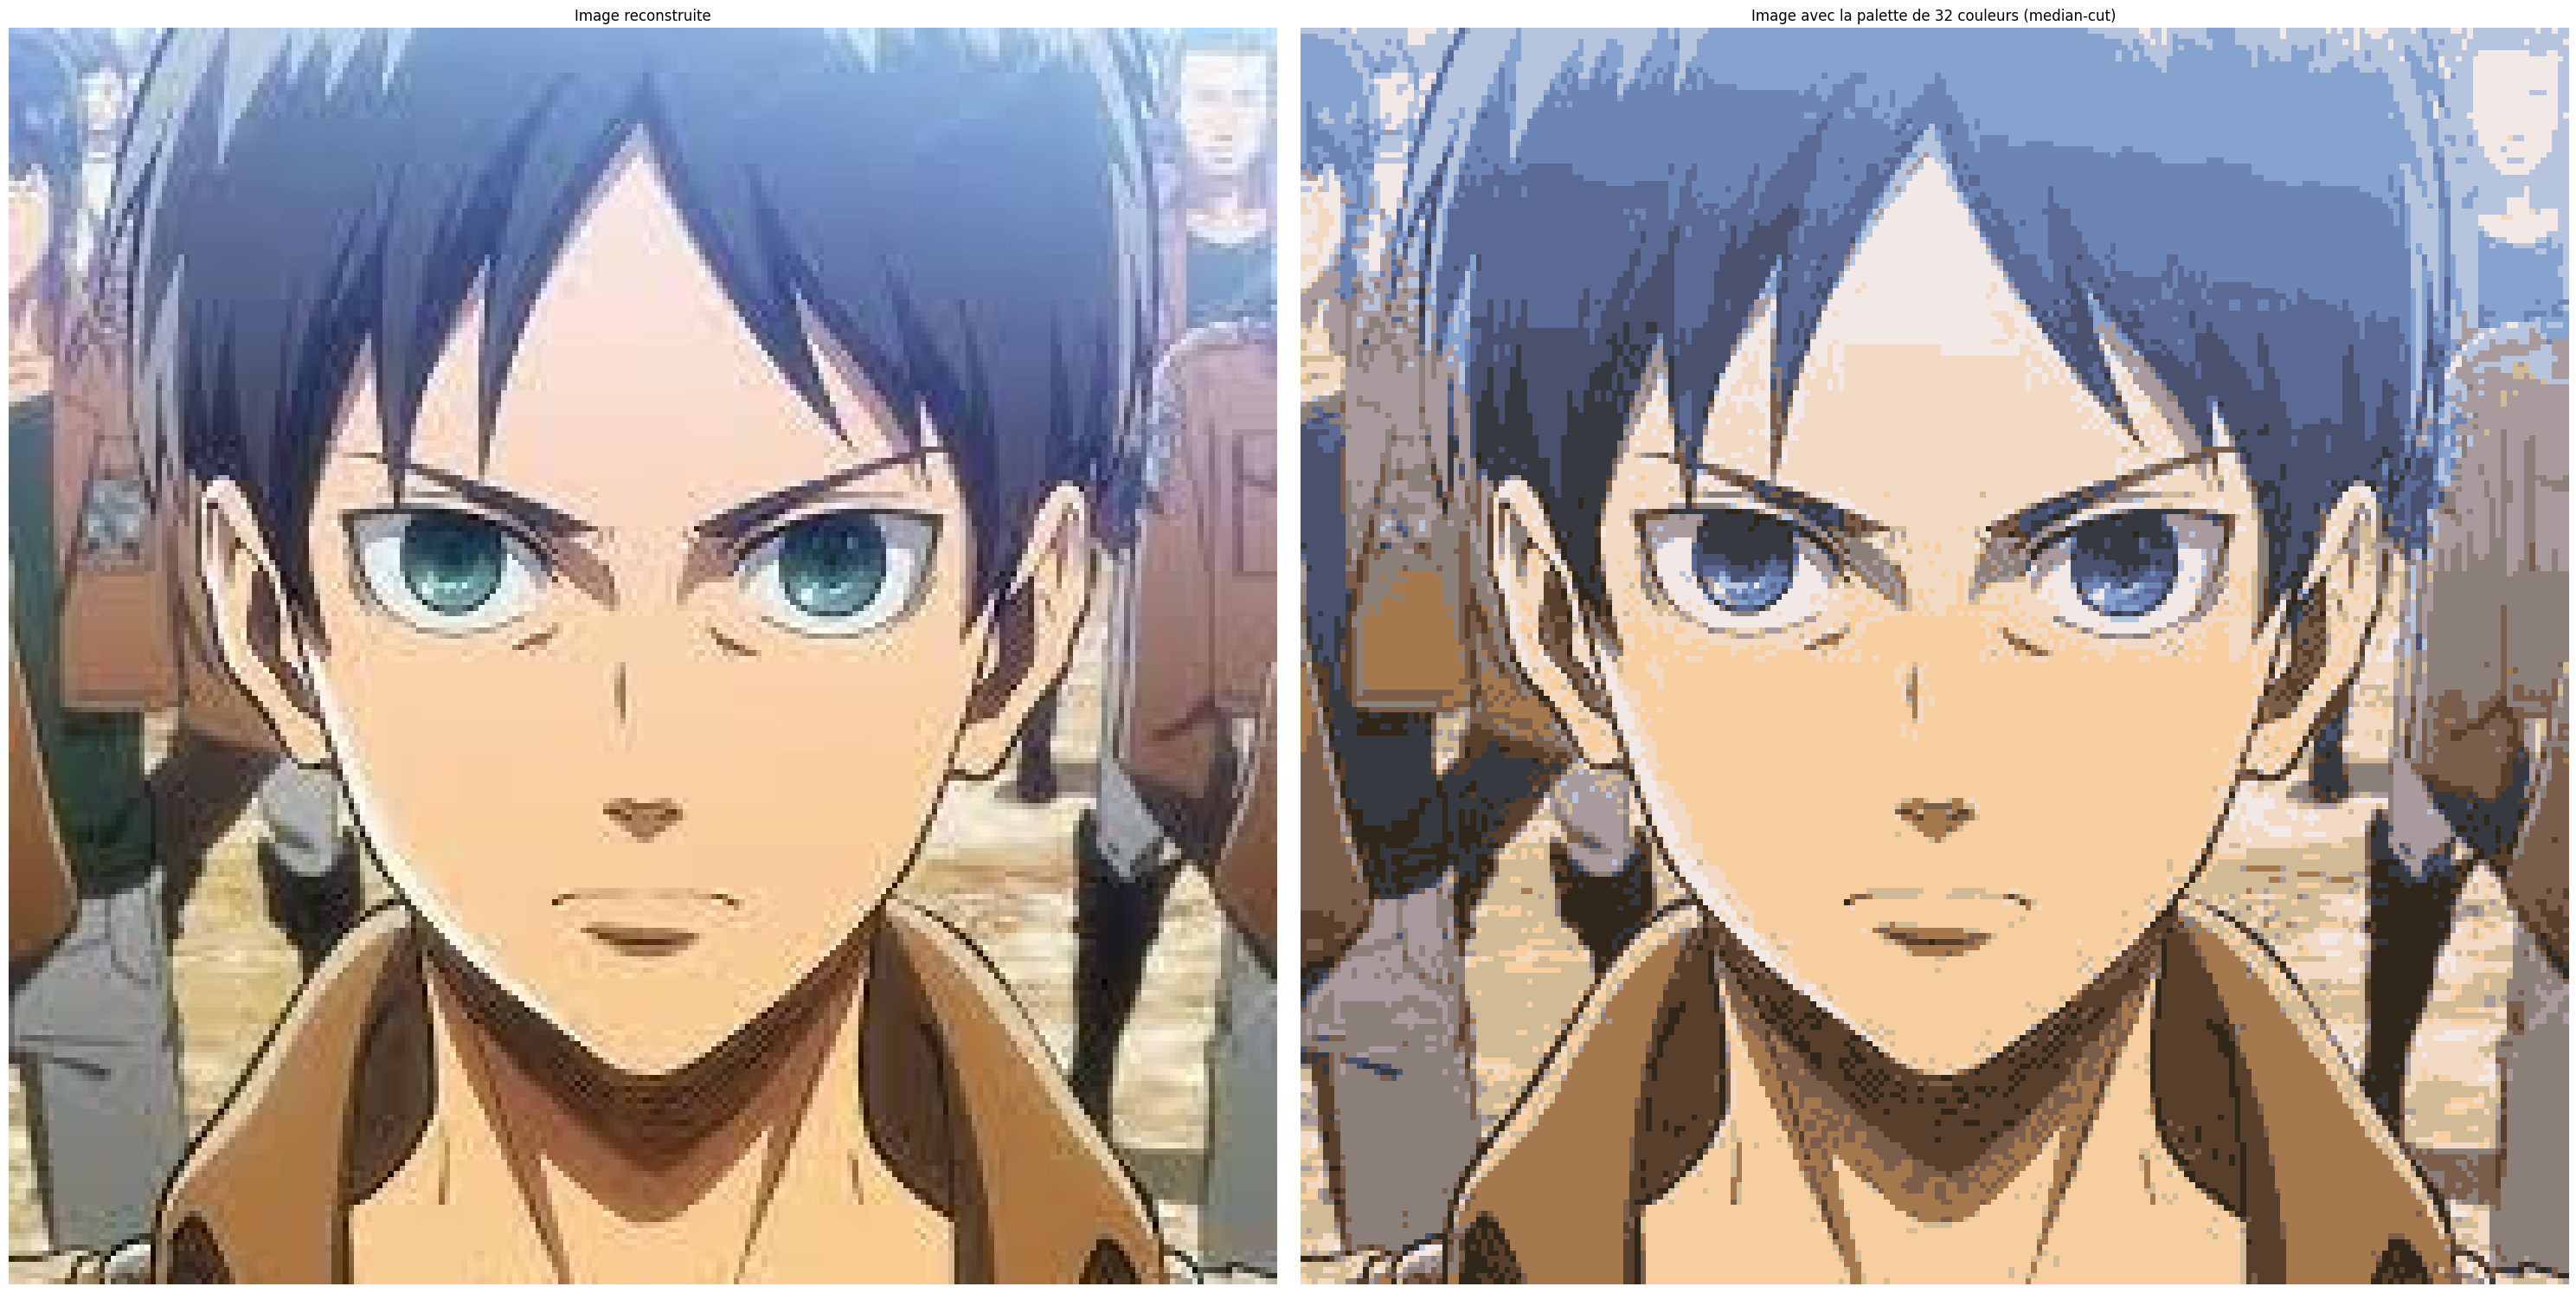

In [289]:
plot_images(image, reconstructed_image_from_mapping1, num_colors)

In [258]:
def subdivision(matrice, taille_blocs):
    # Dimensions de la matrice initiale
    lignes, colonnes = matrice.shape
    
    # Dimensions des blocs
    blocs_lignes, blocs_colonnes = (taille_blocs, taille_blocs)
    
    # Calcul des dimensions des blocs avec zéros ajoutés
    new_blocs_lignes = (lignes + blocs_lignes - 1) // blocs_lignes
    new_blocs_colonnes = (colonnes + blocs_colonnes - 1) // blocs_colonnes
    
    # Initialisation de la matrice des sous-matrices
    sous_matrices = np.zeros((new_blocs_lignes, new_blocs_colonnes, blocs_lignes, blocs_colonnes))
    
    # Remplissage de la matrice des sous-matrices
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            sous_matrices[i, j, :min(blocs_lignes, lignes - i*blocs_lignes), :min(blocs_colonnes, colonnes - j*blocs_colonnes)] = \
                matrice[i*blocs_lignes:(i+1)*blocs_lignes, j*blocs_colonnes:(j+1)*blocs_colonnes]
    
    # Convertir la matrice de sous-matrices en une liste de matrices 2D
    liste_matrices = []
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            liste_matrices.append(sous_matrices[i, j])
    
    return liste_matrices, (lignes, colonnes)

In [259]:
def reconstitution(liste_matrices, dimensions):# Récupération des dimensions de la matrice initiale
    lignes, colonnes = dimensions
    
    # Initialisation de la matrice résultante avec des zéros
    matrice_resultante = np.zeros((lignes, colonnes))
    
    # Dimensions des blocs
    taille_blocs = liste_matrices[0].shape
    
    # Nombre de blocs
    nb_blocs_lignes = (lignes + taille_blocs[0] - 1) // taille_blocs[0]
    nb_blocs_colonnes = (colonnes + taille_blocs[1] - 1) // taille_blocs[1]
    
    # Recombinaison des sous-matrices dans la matrice résultante
    for i in range(nb_blocs_lignes):
        for j in range(nb_blocs_colonnes):
            matrice_resultante[i*taille_blocs[0]:(i+1)*taille_blocs[0], j*taille_blocs[1]:(j+1)*taille_blocs[1]] = \
                liste_matrices[i*nb_blocs_colonnes + j][:min(taille_blocs[0], lignes - i*taille_blocs[0]), :min(taille_blocs[1], colonnes - j*taille_blocs[1])]
    
    return np.array(matrice_resultante, dtype=np.int64)

In [28]:
# Appliquer la fonction de subdivision
liste_blocs, dimensions_originales = subdivision(mapped_indices1, num_blocs)

# Afficher les dimensions de la matrice initiale
print("Dimensions de la matrice initiale :", dimensions_originales)

# Afficher les blocs obtenus après subdivision
print("Blocs obtenus après subdivision :")
for bloc in liste_blocs:
    print(bloc, "\n")

# Appliquer la fonction de reconstitution
matrice_reconstituee = reconstitution(liste_blocs, dimensions_originales)

# Calculer la MSE entre la matrice d'origine et la matrice reconstituée
mse_value = MSE(mapped_indices1, matrice_reconstituee)
print("MSE entre la matrice d'origine et la matrice reconstituée :", mse_value)

# Comparer les matrices d'origine et reconstituée directement
comparaison = np.array_equal(mapped_indices1, matrice_reconstituee)
print("Les matrices d'origine et reconstituée sont identiques :", comparaison)

Dimensions de la matrice initiale : (222, 224)
Blocs obtenus après subdivision :
[[ 8.  8.  8.  8.  8.  8.  8.  4.  8.  9.  8.  8.  8.  8.  8.  8.]
 [ 4.  4.  4.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 4.  4.  4.  4.  4.  4.  8.  8.  8.  4.  8.  8.  8.  8.  8.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  8.  4.  4.  8.  8.  8.  8.  8.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  8.  4.  8.  8.  4.  8.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  4.  4.  8.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  4. 13.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  4.  8.  8.  8.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  9.  9.  9.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  4.  8.  9.  9.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  4.  8.  9.  9.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  8.  8.  9.  9.]
 [ 4. 13.  4.  4.  4.  4.  4.  4.  4.  8.  4.  4

[[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4. 13. 13. 13.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.  4.  4.  4.  4.  4.]
 [13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.  4.  4.  4.]
 [13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 

In [29]:
liste_blocs

[array([[ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  8.,  9.,  8.,  8.,  8.,
          8.,  8.,  8.],
        [ 4.,  4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  8.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  8.,  4.,  8.,  8.,  8.,
          8.,  8.,  4.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  4.,  4.,  8.,  8.,
          8.,  8.,  8.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  8.,  4.,  8.,
          8.,  4.,  8.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  4.,  4.,
          8.,  4.,  4.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  4.,  4.,
          4.,  4.,  4.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  4.,
         13.,  4.,  4.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  4.,
          8.,  8.,  8.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,
          9.,  9.,  9.],
        [ 

In [30]:
matrice_reconstituee

array([[ 8,  8,  8, ...,  9,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  9],
       ...,
       [11, 11, 11, ...,  7,  0,  0],
       [10, 11, 11, ...,  7,  2,  2],
       [ 1, 10, 11, ...,  1, 11,  6]])

In [31]:
mapped_indices1

array([[ 8,  8,  8, ...,  9,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  8],
       [ 4,  4,  4, ...,  8,  8,  9],
       ...,
       [11, 11, 11, ...,  7,  0,  0],
       [10, 11, 11, ...,  7,  2,  2],
       [ 1, 10, 11, ...,  1, 11,  6]])

In [32]:
print(matrice_reconstituee.dtype)
print(mapped_indices1.dtype)

int64
int64


In [33]:
def sous_echantillonnage_4_2_0(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::2, ::2]
    
    return sub_image

In [34]:
def sous_echantillonnage_4_2_2(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::1, ::2]
    
    return sub_image

In [35]:
def sous_echantillonnage_4_4_4(image):
    # La fonction ne fait rien car il n'y a pas de sous-échantillonnage pour le 4:4:4
    return image.copy() 

In [36]:
def inverse_sous_echantillonnage_4_2_0(imSub):
    # Répétition des pixels pour restaurer la résolution horizontale
    H, W = imSub.shape
    res_h = np.repeat(imSub, 2, axis=1)
    
    # Répétition des pixels pour restaurer la résolution verticale
    res_v = np.repeat(res_h, 2, axis=0)
    
    return res_v

In [37]:
def inverse_sous_echantillonnage_4_2_2(imSub):
    # Répétition des colonnes pour restaurer les canaux de chrominance
    res_h = np.repeat(imSub, 2, axis=1)
    
    return res_h

In [38]:
def inverse_sous_echantillonnage_4_4_4(imSub):
    # L'inverse du sous-échantillonnage 4:4:4 est simplement une copie de l'image d'entrée
    return imSub.copy()

In [39]:
# Sous-échantillonnage de l'image
sub_image1 = sous_echantillonnage_4_2_0(liste_blocs[1])

# Répétition des pixels pour restaurer l'image à sa résolution d'origine
reconstituted_image1 = inverse_sous_echantillonnage_4_2_0(sub_image1)

# Calculer la MSE entre l'image d'origine et l'image reconstituée
mse_reconstituted1 = MSE(liste_blocs[1], reconstituted_image1)
print("MSE entre l'image d'origine et l'image reconstituée 1 :", mse_reconstituted1)

MSE entre l'image d'origine et l'image reconstituée 1 : 3.265625


In [40]:
sub_image1

array([[ 8.,  8.,  9.,  9.,  8.,  9.,  5.,  8.],
       [ 8.,  8.,  9.,  8.,  8.,  8.,  4.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  5.,  8.,  8.],
       [ 4.,  8.,  8.,  8.,  8.,  4.,  8.,  8.],
       [ 9.,  9.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  8.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  9.,  8., 13.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  5.,  8.,  8.,  4.,  8.]])

In [41]:
reconstituted_image1

array([[ 8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  9.,  5.,
         5.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  9.,  5.,
         5.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,
         4.,  8.,  8.],
       [ 8.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,  5.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,  5.,  8.,
         8.,  8.,  8.],
       [ 4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  4.,  8.,
         8.,  8.,  8.],
       [ 4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  4.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  4.,  4.,  9.,  9.,  5.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  4.,  4.,  9.,  9.,  5.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  8.,  8.,  4

In [42]:
liste_blocs[1]

array([[ 8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  8.,  5.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8., 13., 13.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8., 13.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,  8.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  8.,  9.,  9.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  9.,  9.,  8.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  8.,  8.,  9.,  4

In [43]:
print(reconstituted_image1.dtype)
print(liste_blocs[1].dtype)

float64
float64


In [44]:
# Sous-échantillonnage de l'image
sub_image2 = sous_echantillonnage_4_2_2(liste_blocs[1])

# Répétition des pixels pour restaurer l'image à sa résolution d'origine
reconstituted_image2 = inverse_sous_echantillonnage_4_2_2(sub_image2)

# Calculer la MSE entre l'image d'origine et l'image reconstituée
mse_reconstituted2 = MSE(liste_blocs[1], reconstituted_image2)
print("MSE entre l'image d'origine et l'image reconstituée 2 :", mse_reconstituted2)

MSE entre l'image d'origine et l'image reconstituée 2 : 2.3203125


In [45]:
sub_image2

array([[ 8.,  8.,  9.,  9.,  8.,  9.,  5.,  8.],
       [ 8.,  8.,  9.,  8.,  8.,  8., 13.,  8.],
       [ 8.,  8.,  9.,  8.,  8.,  8.,  4.,  8.],
       [ 8.,  8.,  8.,  8.,  8., 13.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  5.,  8.,  8.],
       [ 4.,  4.,  8.,  8.,  8.,  5.,  8.,  8.],
       [ 4.,  8.,  8.,  8.,  8.,  4.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  4.,  8.,  8.,  8.],
       [ 9.,  9.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  9.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  8.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  8.,  4.,  8.,  8.,  8.],
       [ 9.,  9.,  8., 13.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  5.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  5.,  8.,  8.,  4.,  8.],
       [ 9.,  9.,  9.,  5.,  8.,  8.,  4.,  8.]])

In [46]:
reconstituted_image2

array([[ 8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  9.,  5.,
         5.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8., 13.,
        13.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,  5.,  8.,
         8.,  8.,  8.],
       [ 4.,  4.,  4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,  5.,  8.,
         8.,  8.,  8.],
       [ 4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  4.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  8.,  4.,  4.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  4.,  4.,  9.,  9.,  5.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  4.,  4.,  9.,  9.,  5.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  8.,  8.,  4

In [47]:
liste_blocs[1]

array([[ 8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  8.,  5.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8., 13., 13.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8., 13.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,  8.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  8.,  9.,  9.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  9.,  9.,  8.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  8.,  8.,  9.,  4

In [48]:
print(reconstituted_image2.dtype)
print(liste_blocs[1].dtype)

float64
float64


In [49]:
# Sous-échantillonnage de l'image
sub_image3 = sous_echantillonnage_4_4_4(liste_blocs[1])

# Répétition des pixels pour restaurer l'image à sa résolution d'origine
reconstituted_image3 = inverse_sous_echantillonnage_4_4_4(sub_image3)

# Calculer la MSE entre l'image d'origine et l'image reconstituée
mse_reconstituted3 = MSE(liste_blocs[1], reconstituted_image3)
print("MSE entre l'image d'origine et l'image reconstituée 3 :", mse_reconstituted3)

MSE entre l'image d'origine et l'image reconstituée 3 : 0.0


In [50]:
sub_image3

array([[ 8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  8.,  5.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8., 13., 13.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8., 13.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,  8.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  8.,  9.,  9.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  9.,  9.,  8.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  8.,  8.,  9.,  4

In [51]:
reconstituted_image3

array([[ 8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  8.,  5.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8., 13., 13.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8., 13.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,  8.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  8.,  9.,  9.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  9.,  9.,  8.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  8.,  8.,  9.,  4

In [52]:
liste_blocs[1]

array([[ 8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,  8.,  5.,
         4.,  8.,  8.],
       [ 8.,  8.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8., 13., 13.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,
         8.,  8.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  4.,  4.,  8.,  8.,  8.,  8.,  8., 13.,  5.,  8.,  8.,
         8.,  8.,  8.],
       [ 4.,  8.,  8.,  4.,  8.,  8.,  8.,  8.,  8.,  5.,  4.,  8.,  8.,
         8.,  8.,  8.],
       [ 8.,  8.,  8.,  4.,  4.,  8.,  8.,  8.,  4.,  5.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  8.,  9.,  9.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  9.,  9.,  8.,  4.,  9.,  9.,  8.,  5.,  4.,  8.,  8.,  8.,
         8.,  8.,  8.],
       [ 9.,  8.,  8.,  9.,  4

In [53]:
print(reconstituted_image3.dtype)
print(liste_blocs[1].dtype)

float64
float64


In [54]:
def apply_dct(matrix):
    # Appliquer la DCT à chaque matrice
    dct_matrix = dct(dct(matrix.T, norm='ortho').T, norm='ortho')
    
    return np.array(dct_matrix)

In [55]:
def inverse_dct(dct_matrix):
    # Appliquer l'inverse de la DCT à chaque matrice
    inverse_dct_matrix = idct(idct(dct_matrix, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return np.round(inverse_dct_matrix)

In [56]:
# Appliquer la DCT à la matrice d'indices mappés
dct_matrix = apply_dct(sub_image1)

# Appliquer l'inverse de la DCT à la matrice après DCT
reconstituted_matrix = inverse_dct(dct_matrix)

# Calculer la MSE entre la matrice d'indices mappés et la matrice reconstituée après inverse DCT
mse_reconstituted = MSE(sub_image1, reconstituted_matrix)
print("MSE entre la matrice sous échantillonnée et la matrice reconstituée après inverse DCT :", mse_reconstituted)

MSE entre la matrice sous échantillonnée et la matrice reconstituée après inverse DCT : 0.0


In [57]:
dct_matrix

array([[ 6.08750000e+01,  1.84920615e+00,  1.63320371e-01,
        -1.42520479e+00,  2.87500000e+00, -1.16970853e-01,
         6.76495125e-02, -2.88929849e+00],
       [-9.37318029e-01, -4.96951926e-01, -2.01423492e+00,
        -1.69359361e+00,  2.03283714e-01, -3.68761593e-01,
         1.85091025e+00,  2.19800424e+00],
       [ 2.22563479e+00,  2.82097351e+00, -1.52404852e+00,
         8.13880639e-01,  2.80213456e-02, -2.95232650e+00,
         4.34359217e+00,  2.28086507e-01],
       [ 1.81940392e+00,  1.40749909e-01,  9.12580032e-01,
         1.91027230e+00, -2.81136888e-01,  1.49715103e+00,
        -9.66084371e-01, -5.11057013e+00],
       [-1.12500000e+00,  2.40943723e-01,  6.25260137e-01,
        -1.76354092e-01, -1.62500000e+00, -2.80877848e+00,
        -1.23692204e-01,  2.90015217e-01],
       [ 1.56794651e+00, -1.01595404e+00, -2.74339650e+00,
        -2.68482949e+00,  2.88952620e-01,  1.81460144e+00,
        -1.93912174e+00,  1.31752660e+00],
       [-2.13957934e+00, -1.209924

In [58]:
reconstituted_matrix

array([[ 8.,  8.,  9.,  9.,  8.,  9.,  5.,  8.],
       [ 8.,  8.,  9.,  8.,  8.,  8.,  4.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  5.,  8.,  8.],
       [ 4.,  8.,  8.,  8.,  8.,  4.,  8.,  8.],
       [ 9.,  9.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  8.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  9.,  8., 13.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  5.,  8.,  8.,  4.,  8.]])

In [59]:
sub_image1

array([[ 8.,  8.,  9.,  9.,  8.,  9.,  5.,  8.],
       [ 8.,  8.,  9.,  8.,  8.,  8.,  4.,  8.],
       [ 8.,  4.,  8.,  8.,  8.,  5.,  8.,  8.],
       [ 4.,  8.,  8.,  8.,  8.,  4.,  8.,  8.],
       [ 9.,  9.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  8.,  4.,  9.,  5.,  8.,  8.,  8.],
       [ 9.,  9.,  8., 13.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  8.,  5.,  8.,  8.,  4.,  8.]])

In [60]:
print(reconstituted_matrix.dtype)
print(sub_image1.dtype)

float64
float64


In [61]:
def wrap_border(matrix, num_blocs):
    if num_blocs == 32:
      border_size = int(matrix.shape[0] / 2)
      # Dimensions de la matrice d'origine
      rows, cols = matrix.shape

      # Matrice résultante avec une taille supplémentaire pour les bords répétés
      wrapped_rows = rows + 2 * border_size
      wrapped_cols = cols + 2 * border_size
      wrapped_matrix = np.zeros((wrapped_rows, wrapped_cols))

      # Copie des valeurs de la matrice d'origine au centre de la matrice résultante
      wrapped_matrix[border_size:border_size + rows, border_size:border_size + cols] = matrix

      # Répétition des bords de la matrice d'origine
      wrapped_matrix[:border_size, border_size:border_size + cols] = matrix[-border_size:, :]  # Bord supérieur
      wrapped_matrix[-border_size:, border_size:border_size + cols] = matrix[:border_size, :]  # Bord inférieur
      wrapped_matrix[border_size:border_size + rows, :border_size] = matrix[:, -border_size:]  # Bord gauche
      wrapped_matrix[border_size:border_size + rows, -border_size:] = matrix[:, :border_size]  # Bord droit

      # Coins
      wrapped_matrix[:border_size, :border_size] = matrix[-border_size:, -border_size:]  # Coin supérieur gauche
      wrapped_matrix[:border_size, -border_size:] = matrix[-border_size:, :border_size]   # Coin supérieur droit
      wrapped_matrix[-border_size:, :border_size] = matrix[:border_size, -border_size:]   # Coin inférieur gauche
      wrapped_matrix[-border_size:, -border_size:] = matrix[:border_size, :border_size]    # Coin inférieur droit

      return wrapped_matrix
    else:
      return matrix

In [62]:
def quantization(matrix, num_blocsQ):
  quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                  [12, 12, 14, 19, 26, 58, 60, 55],
                                  [14, 13, 16, 24, 40, 57, 69, 56],
                                  [14, 17, 22, 29, 51, 87, 80, 62],
                                  [18, 22, 37, 56, 68, 109, 103, 77],
                                  [24, 35, 55, 64, 81, 104, 113, 92],
                                  [49, 64, 78, 87, 103, 121, 120, 101],
                                  [72, 92, 95, 98, 112, 100, 103, 99]])
  
  quantization_matrix = wrap_border(quantization_matrix, num_blocsQ)
  
  matrix = np.round(matrix / quantization_matrix)
  return matrix

In [63]:
def dequantization(matrix, blocsD):
  quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                  [12, 12, 14, 19, 26, 58, 60, 55],
                                  [14, 13, 16, 24, 40, 57, 69, 56],
                                  [14, 17, 22, 29, 51, 87, 80, 62],
                                  [18, 22, 37, 56, 68, 109, 103, 77],
                                  [24, 35, 55, 64, 81, 104, 113, 92],
                                  [49, 64, 78, 87, 103, 121, 120, 101],
                                  [72, 92, 95, 98, 112, 100, 103, 99]])
  
  quantization_matrix = wrap_border(quantization_matrix, blocsD)
  
  matrix = np.round(matrix * quantization_matrix)
  return matrix

In [64]:
# Appliquer la quantification à la matrice DCT
quant_image = quantization(dct_matrix, num_blocs)

# Appliquer l'inverse de la quantification à la matrice après quantification
inverse_quant = dequantization(quant_image, num_blocs)

# Calculer la MSE entre la matrice DCT et la matrice reconstituée après quantification
mse_reconstituted = MSE(dct_matrix, inverse_quant)
print("MSE entre la matrice DCT et la matrice reconstituée après quantification :", mse_reconstituted)

MSE entre la matrice DCT et la matrice reconstituée après quantification : 3.0468749999999982


In [65]:
quant_image

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [66]:
inverse_quant

array([[64.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [67]:
dct_matrix

array([[ 6.08750000e+01,  1.84920615e+00,  1.63320371e-01,
        -1.42520479e+00,  2.87500000e+00, -1.16970853e-01,
         6.76495125e-02, -2.88929849e+00],
       [-9.37318029e-01, -4.96951926e-01, -2.01423492e+00,
        -1.69359361e+00,  2.03283714e-01, -3.68761593e-01,
         1.85091025e+00,  2.19800424e+00],
       [ 2.22563479e+00,  2.82097351e+00, -1.52404852e+00,
         8.13880639e-01,  2.80213456e-02, -2.95232650e+00,
         4.34359217e+00,  2.28086507e-01],
       [ 1.81940392e+00,  1.40749909e-01,  9.12580032e-01,
         1.91027230e+00, -2.81136888e-01,  1.49715103e+00,
        -9.66084371e-01, -5.11057013e+00],
       [-1.12500000e+00,  2.40943723e-01,  6.25260137e-01,
        -1.76354092e-01, -1.62500000e+00, -2.80877848e+00,
        -1.23692204e-01,  2.90015217e-01],
       [ 1.56794651e+00, -1.01595404e+00, -2.74339650e+00,
        -2.68482949e+00,  2.88952620e-01,  1.81460144e+00,
        -1.93912174e+00,  1.31752660e+00],
       [-2.13957934e+00, -1.209924

In [68]:
print(inverse_quant.dtype)
print(dct_matrix.dtype)

float64
float64


In [69]:
def ligne_scan(matrice):
  shape = matrice.shape
  vecteur = matrice.flatten()
  return np.array(vecteur), shape

In [70]:
def colonne_scan(matrice):
    shape = matrice.shape
    vecteur = np.ravel(matrice, order = 'F')
    return np.array(vecteur), shape

In [71]:
def zigzag_scan(matrice):
  shape = matrice.shape
  vecteur = np.concatenate([np.diagonal(matrice[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1 - matrice.shape[0], matrice.shape[0])])
  return np.array(vecteur), shape

In [72]:
def inverse_ligne_scan(vecteur, shape):
  mat = np.array(vecteur).reshape((shape[0], shape[1]))
  return mat

In [73]:
def inverse_colonne_scan(vecteur, shape):
    mat = np.array(vecteur).reshape((shape[0], shape[1]))
    return mat.T

In [74]:
def inverse_zigzag_scan(vector, shape):
    rows, cols = shape
    mat = np.zeros((rows, cols))
    row, col = 0, 0
    direction = 1

    for i in range(rows * cols):
        mat[row][col] = vector[i]
        if direction == 1:
            if col == cols - 1:
                row += 1
                direction = -1
            elif row == 0:
                col += 1
                direction = -1
            else:
                row -= 1
                col += 1
        else:
            if row == rows - 1:
                col += 1
                direction = 1
            elif col == 0:
                row += 1
                direction = 1
            else:
                row += 1
                col -= 1

    return mat

In [75]:
# Compression de l'image
vecteur_comprime1, shape = ligne_scan(quant_image)

# Décompression de l'image
vecteur_reconst1 = inverse_ligne_scan(vecteur_comprime1, shape)

# Calcul du MSE entre l'image originale et celle reconstruite
mse_value1 = MSE(quant_image, vecteur_reconst1)
print("MSE entre la matrice d'origine et la matrice reconstituée :", mse_value1)

# Comparer les matrices d'origine et reconstituée directement
comparaison1 = np.array_equal(quant_image, vecteur_reconst1)
print("Les matrices d'origine et reconstituée sont identiques :", comparaison1)

MSE entre la matrice d'origine et la matrice reconstituée : 0.0
Les matrices d'origine et reconstituée sont identiques : True


In [76]:
vecteur_comprime1

array([ 4.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  0.,
       -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,
        0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

In [77]:
vecteur_reconst1

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [78]:
quant_image

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [79]:
print(vecteur_reconst1.dtype)
print(quant_image.dtype)

float64
float64


In [80]:
# Compression de l'image
vecteur_comprime2, shape = colonne_scan(quant_image)

# Décompression de l'image
vecteur_reconst2 = inverse_colonne_scan(vecteur_comprime2, shape)

# Calcul du MSE entre l'image originale et celle reconstruite
mse_value2 = MSE(quant_image, vecteur_reconst2)
print("MSE entre la matrice d'origine et la matrice reconstituée :", mse_value2)

# Comparer les matrices d'origine et reconstituée directement
comparaison2 = np.array_equal(quant_image, vecteur_reconst2)
print("Les matrices d'origine et reconstituée sont identiques :", comparaison2)

MSE entre la matrice d'origine et la matrice reconstituée : 0.0
Les matrices d'origine et reconstituée sont identiques : True


In [81]:
vecteur_comprime2

array([ 4., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
       -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,
        0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
       -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.])

In [82]:
vecteur_reconst2

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [107]:
quant_image

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [108]:
print(vecteur_reconst2.dtype)
print(quant_image.dtype)

float64
float64


In [109]:
# Compression de l'image
vecteur_comprime3, shape = zigzag_scan(quant_image)

# Décompression de l'image
vecteur_reconst3 = inverse_zigzag_scan(vecteur_comprime3, shape)

# Calcul du MSE entre l'image originale et celle reconstruite
mse_value3 = MSE(quant_image, vecteur_reconst3)
print("MSE entre la matrice d'origine et la matrice reconstituée :", mse_value3)

# Comparer les matrices d'origine et reconstituée directement
comparaison3 = np.array_equal(quant_image, vecteur_reconst3)
print("Les matrices d'origine et reconstituée sont identiques :", comparaison3)

MSE entre la matrice d'origine et la matrice reconstituée : 0.0
Les matrices d'origine et reconstituée sont identiques : True


In [110]:
vecteur_comprime3

array([ 4.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

In [111]:
vecteur_reconst3

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [112]:
quant_image

array([[ 4.,  0.,  0., -0.,  0., -0.,  0., -0.],
       [-0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [113]:
print(vecteur_reconst3.dtype)
print(quant_image.dtype)

float64
float64


In [126]:
def list_to_string(lst):
    # Convertit chaque nombre en chaîne de caractères et les joint avec des virgules
    vect = lst.astype(np.int8)
    
    string = ''.join(str(num) for num in vect.tolist())
    lengths = [len(str(i)) for i in vect.tolist()]
    
    return string, lengths

def string_to_list(string, lengths):
    mat = np.zeros(len(lengths))
    start = 0
    lst = []
    for length in lengths:
        num_str = string[start:start+length]
        lst.append(int(num_str))
        start += length
    mat[:] = lst
    return mat

In [134]:
# Exemple d'utilisation
chaine, lengths = list_to_string(vecteur_comprime1)
print("Le vecteur initial: ", vecteur_comprime1)
print("Liste transformée en chaîne:", chaine)
print("Longueur des valeurs: ", lengths)

nouvelle_liste = string_to_list(chaine, lengths)
print("Chaîne transformée en liste:", nouvelle_liste)
print((vecteur_comprime1 == nouvelle_liste).all())

Le vecteur initial:  [ 4.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.
 -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0.
 -0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.]
Liste transformée en chaîne: 4000000000000000000000000000000000000000000000000000000000000000
Longueur des valeurs:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Chaîne transformée en liste: [4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True


In [139]:
chaine

'4000000000000000000000000000000000000000000000000000000000000000'

In [135]:
nouvelle_liste

array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [136]:
vecteur_comprime1

array([ 4.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  0.,
       -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,
        0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

In [137]:
print(nouvelle_liste.dtype)
print(vecteur_comprime3.dtype)

float64
float64


In [140]:

def sym_occ(data):
    if isinstance(data, list):
        data += [str(i) for i in data]
    encoded_data = []
    
    for char in data:
        if not encoded_data:
            encoded_data.append((char, 1))
        else:
            last = encoded_data[-1]
            if last[0] == char:
                encoded_data[-1] = (last[0], last[1] + 1)
            else:
                encoded_data.append((char, 1))
                
    return encoded_data

In [141]:
def encoding_RLE(data):
    encoded_data = sym_occ(data)
    code = []
    
    for _, (i, j) in enumerate(encoded_data):
        courant = i + str(j)
        code.append(courant)
    return code

In [142]:
def decoding_RLE(data):
    chaine = ""
    
    for i in data:
        carac = i[0]
        occ = i[1:]
        chaine += carac * int(occ)
    return chaine

In [143]:
encoded_string = encoding_RLE(chaine)
decoded_string = decoding_RLE(encoded_string)

print("Original:", chaine)
print("Encoded:", encoded_string)
print("Decoded:", decoded_string)

Original: 4000000000000000000000000000000000000000000000000000000000000000
Encoded: ['41', '063']
Decoded: 4000000000000000000000000000000000000000000000000000000000000000


In [144]:
encoded_string

['41', '063']

In [145]:
decoded_string

'4000000000000000000000000000000000000000000000000000000000000000'

In [146]:
chaine

'4000000000000000000000000000000000000000000000000000000000000000'

In [148]:
print(type(decoded_string))
print(type(chaine))

<class 'str'>
<class 'str'>


In [149]:
def ext_chr(chaine):
    occ = {c: chaine.count(c) for c in set(chaine)}
    return sorted(occ.items(), key=lambda x: x[1], reverse=True)

# Fonction principale implémentant le codage de Huffman
def huffman_dictionnary_code(node, binString=''):
    if isinstance(node, str):
        return {node: binString}
    (l, r) = node
    d = {}
    d.update(huffman_dictionnary_code(l, binString + '0'))
    d.update(huffman_dictionnary_code(r, binString + '1'))
    return d

# Construction de l'arbre de Huffman
def huffman_tree(chaine):
    nodes = ext_chr(chaine)
    
    while len(nodes) > 1:
        (key1, c1) = nodes.pop()
        (key2, c2) = nodes.pop()
        node = (key1, key2)
        nodes.append((node, c1 + c2))
        nodes.sort(key=lambda x: x[1], reverse=True)
        
    return nodes[0][0]


In [181]:
def encoding_huffman(liste):
    string = ''.join(liste)
    lengths = [len(i) for i in liste]
    
    nodes = huffman_tree(string)
    huffmanCode = huffman_dictionnary_code(nodes)
    
    compressed_string = ''
    for char in string:
        compressed_string += huffmanCode[char]
    return compressed_string, nodes, lengths

In [186]:
def decoding_huffman(compressed_string, huffman_tree, lengths):
    decoded_string = ''
    current_node = huffman_tree
    
    for bit in compressed_string:
        if bit == '0':
            current_node = current_node[0]
        else:
            current_node = current_node[1]
        
        if isinstance(current_node, str):
            decoded_string += current_node
            current_node = huffman_tree
    
    lst = []
    start = 0
    
    for length in lengths:
        num_str = decoded_string[start:start+length]
        lst.append(num_str)
        start += length
    
    return lst

In [187]:
compressed_text, tree, lengths = encoding_huffman(encoded_string)
decompressed_text = decoding_huffman(compressed_text, tree, lengths)

print("Texte original:", encoded_string)
print("Texte compressé:", compressed_text)
print("Texte décompressé:", decompressed_text)

Texte original: ['41', '063']
Texte compressé: 001110110110
Texte décompressé: ['41', '063']


In [188]:
compressed_text

'001110110110'

In [189]:
decompressed_text

['41', '063']

In [190]:
encoded_string

['41', '063']

In [191]:
print(type(decompressed_text))
print(type(encoded_string))

<class 'list'>
<class 'list'>


In [203]:
def fusionner(strings_list):
    tailles = []
    string_fusionned = ""
    
    # Parcourir tous les éléments de la liste
    for string in strings_list:
        # Convertir chaque nombre en chaîne de caractères et l'ajouter à la chaîne fusionnée
        string_fusionned += string
        
        # Ajouter la taille de l'élément à la liste des tailles
        tailles.append(len(string))
    
    # Retourner la chaîne de caractères fusionnée et la liste des tailles
    return string_fusionned, tailles

In [204]:
def separer(string_fusionned, tailles):
    strings_list = []
    debut = 0
    
    # Parcourir toutes les tailles dans la liste
    for taille in tailles:
        # Extraire le sous-chaîne correspondant à la taille actuelle
        sous_chaine = string_fusionned[debut:debut+taille]
        
        # Convertir la sous-chaîne en nombre et l'ajouter à la liste des nombres
        strings_list.append(sous_chaine)
        
        # Mettre à jour la position de départ pour la prochaine sous-chaîne
        debut += taille
    
    # Retourner la liste des nombres
    return strings_list

In [205]:
def encoding_lzw(data):
    alphabet = ['0', '1']
    data_fused, taille = fusionner(data)  # Fusionner les chaînes de caractères
    encoded_data = []

    dictionary = {}  # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[char] = i

    prefix = ''
    for char in data_fused:
        new_entry = prefix + char
        if new_entry in dictionary:
            prefix = new_entry
        else:
            encoded_data.append(dictionary[prefix])
            dictionary[new_entry] = len(dictionary)
            prefix = char

    if prefix:
        encoded_data.append(dictionary[prefix])

    return encoded_data, taille

In [206]:
def decoding_lzw(compressed_data, taille):
    alphabet = ['0', '1']
    result = []
    dictionary = {}
    current_code = len(alphabet)

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[i] = char

    old_entry = dictionary[compressed_data[0]]
    result.append(old_entry)
    for new_entry in compressed_data[1:]:
        if new_entry in dictionary:
            entry = dictionary[new_entry]
        elif new_entry == current_code:
            entry = old_entry + old_entry[0]
        else:
            raise ValueError("Mauvaise séquence compressée")

        result.append(entry)

        # Utilisez le même dictionnaire pour la décompression
        dictionary[current_code] = old_entry + entry[0]
        current_code += 1
        old_entry = entry

    result = ''.join(result)
    result = separer(result, taille)
    
    return result

In [207]:
binary_strings = [
    "1010", 
    "110011", 
    "111000111", 
    "10101010", 
    "111100001111", 
    "101010101010", 
    "1100110011001100", 
    "111000111000111", 
    "1010101010101010", 
    "11110000111100001111"
]

In [208]:
# Encodage des données
encoded_data, taille = encoding_lzw(binary_strings)
print("Données encodées:", encoded_data)

# Décodage des données encodées
decoded_data = decoding_lzw(encoded_data, taille)
print("Données décodées:", decoded_data)
print("Données initiales:", binary_strings)
print("Données décodées == données initiales ?:", binary_strings == decoded_data)

Données encodées: [1, 0, 2, 1, 2, 3, 5, 5, 0, 10, 8, 4, 3, 14, 12, 10, 11, 16, 13, 20, 7, 18, 23, 22, 7, 6, 26, 17, 19, 15, 31, 20, 8, 17, 26, 27, 36]
Données décodées: ['1010', '110011', '111000111', '10101010', '111100001111', '101010101010', '1100110011001100', '111000111000111', '1010101010101010', '11110000111100001111']
Données initiales: ['1010', '110011', '111000111', '10101010', '111100001111', '101010101010', '1100110011001100', '111000111000111', '1010101010101010', '11110000111100001111']
Données décodées == données initiales ?: True


In [260]:
def intermediaire_compression(imageA, num_colorsA):
  color_paletteA, palette_indicesA = kmeans_clustering_palette(imageA, num_colorsA)
  mapped_indicesA = map_to_palette(imageA, color_paletteA)
  liste_blocsA, dimensions_originalesA = subdivision(mapped_indicesA, 16)
  lengthssA1 = []
  lengthssA2 = []
  compressed_textsA = []
  treesA = []
  
  for blocA in liste_blocsA:
    sub_imageA = sous_echantillonnage_4_2_0(blocA)
    dct_matrixA = apply_dct(sub_imageA)
    quant_imageA = quantization(dct_matrixA, 16)
    vecteur_comprimeA, shapeA = ligne_scan(quant_imageA)
    chaineA, lengthsA1 = list_to_string(vecteur_comprimeA)
    encoded_stringA = encoding_RLE(chaineA)
    compressed_textA, treeA, lengthsA2 = encoding_huffman(encoded_stringA)
    lengthssA1.append(lengthsA1)
    lengthssA2.append(lengthsA2)
    compressed_textsA.append(compressed_textA)
    treesA.append(treeA)
    
  encoded_dataA, tailleA = encoding_lzw(compressed_textsA)
  
  return encoded_dataA, color_paletteA, palette_indicesA, dimensions_originalesA, shapeA, lengthssA1, treesA, lengthssA2, tailleA

In [261]:
result1 = intermediaire_compression(image, num_colors)

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(222, 224)


In [282]:
def intermediaire_decompression(encoded_dataB, color_paletteB, palette_indicesB, dimensions_originalesB, shapeB, lengthssB1, treesB, lengthssB2, tailleB):
  decompressed_textB = decoding_lzw(encoded_dataB, tailleB)
  liste_blocsB = []
  
  for i in range(len(decompressed_textB)):
    encoded_stringB = decoding_huffman(decompressed_textB[i], treesB[i], lengthssB2[i])
    chaineB = decoding_RLE(encoded_stringB)
    vecteur_comprimeB = string_to_list(chaineB, lengthssB1[i])
    quant_imageB = inverse_ligne_scan(vecteur_comprimeB, shapeB)
    dct_matrixB = dequantization(quant_imageB, 16)
    sub_imageB = inverse_dct(dct_matrixB)
    blocB = inverse_sous_echantillonnage_4_2_0(sub_imageB)
    liste_blocsB.append(blocB)
  
  mapped_indicesB = reconstitution(liste_blocsB, dimensions_originalesB)
  imageB = inverse_map_to_palette(mapped_indicesB, color_paletteB)
  reconstructed_imageB = inverse_kmeans_clustering_palette(color_paletteB, palette_indicesB)
  
  return imageB

In [283]:
result2 = intermediaire_decompression(result[0], result[1], result[2], result[3], result[4], result[5], result[6], result[7], result[8])

In [291]:
result2.size

(224, 222)

In [284]:
plot_images(image, Image.fromarray(result2), num_colors)

TypeError: a bytes-like object is required, not 'Image'